# Bundesliga Web Scraping 
## The following code is aimed to get information about the matches of the Bundesliga Tournament from 2015 to 2025 (Season 2015/2016 - 2024/2025) for the MA Economics and Management thesis paper.
### Author: José Saúl Barrientos Rivera
### Supervisor: Thorsten Hens
#### First version: 30.08.2025
#### This version: 11.12.2025

### HTML Code to obtain formations

In [63]:
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas.plotting import table
import random
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [69]:
def get_page_html(url):
    """
    Obtiene solo el HTML crudo de la página especificada
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        print(f"Obteniendo HTML de: {url}")
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            # Devolver el HTML crudo
            return response.text
        else:
            print(f"Error: Código de estado {response.status_code}")
            return None
            
    except Exception as e:
        print(f"Error al obtener la página: {e}")
        return None

# URL específica que quieres analizar
url = "https://www.sportschau.de/live-und-ergebnisse/fussball/deutschland-bundesliga/ma8935950/bayern-muenchen_fc-schalke-04/taktische-aufstellung"

# Obtener el HTML
html_content = get_page_html(url)

if html_content:
    # Mostrar información básica
    print(f"Tamaño del HTML: {len(html_content)} caracteres")
    print("\nPrimeros 1000 caracteres del HTML:")
    print("=" * 50)
    print(html_content[:1000])
    print("..." * 20)
    
    # También puedes guardarlo en un archivo para analizarlo después
    with open("formations.html", "w", encoding="utf-8") as f:
        f.write(html_content)
    print(f"\nHTML guardado en: formations.html")
    
    # Si quieres ver la estructura básica con BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')
    print(f"\nTítulo de la página: {soup.title.text if soup.title else 'No encontrado'}")
    
else:
    print("No se pudo obtener el HTML de la página")

Obteniendo HTML de: https://www.sportschau.de/live-und-ergebnisse/fussball/deutschland-bundesliga/ma8935950/bayern-muenchen_fc-schalke-04/taktische-aufstellung
Tamaño del HTML: 414253 caracteres

Primeros 1000 caracteres del HTML:
<!DOCTYPE html>

<html xmlns="http://www.w3.org/1999/xhtml"
      lang="de">



    
    
        <head>

    
    
    
    

    <meta charset="UTF-8"/>
    <meta name="viewport" content="width=device-width"/>

    

    
        <title>Fußball Bundesliga: FC Bayern gegen Schalke - Aufstellung - 19. Spieltag - 2019/2020 | Sportschau.de</title>
<meta property="og:title" content="Fußball Bundesliga: FC Bayern gegen Schalke - Aufstellung - 19. Spieltag - 2019/2020 | Sportschau.de" />
        <meta property="og:url" content="https://www.sportschau.de/live-und-ergebnisse/fussball/deutschland-bundesliga/ma8935950/bayern-muenchen_fc-schalke-04/taktische-aufstellung" />
<link rel="canonical" href="https://www.sportschau.de/live-und-ergebnisse/fussball/deutschland-b

### Obtain the formations for the seasons 2015/16 to 2024/25
#### The season code (for example: se18336 for 2015-2016) is taken manually from the website year by year for accuracy.

In [ ]:
def get_season_codes():
    """
    Manual mapping of Bundesliga season codes
    """
    season_codes = {
        "2015-2016": "se18336",
        "2016-2017": "se20812",
        "2017-2018": "se23906",
        "2018-2019": "se28567", 
        "2019-2020": "se31723",
        "2020-2021": "se35753",
        "2021-2022": "se39227",
        "2022-2023": "se45495",
        "2023-2024": "se51884",
        "2024-2025": "se74723"
    }
    
    print("=== SEASON CODES ===")
    for season, code in season_codes.items():
        print(f"Season: {season} -> Code: {code}")
    
    return season_codes

def get_bundesliga_formations():
    """
    Gets Bundesliga formation data from Sportschau.de for all seasons
    """
    all_matches = []
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    # Get season codes
    season_codes = get_season_codes()
    
    # Process ALL seasons
    for target_season, season_code in season_codes.items():
        print(f"\n{'='*50}")
        print(f"Processing season: {target_season} with code: {season_code}")
        print(f"{'='*50}")
        
        # Correct base URL for the season
        base_url = f"https://www.sportschau.de/live-und-ergebnisse/fussball/deutschland-bundesliga/{season_code}/{target_season}/spiele-und-ergebnisse"
        
        print(f"URL: {base_url}")
        
        try:
            response = requests.get(base_url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Find the matchday selector
            matchday_select = soup.find('select', class_='round-navigation')
            if not matchday_select:
                print(f"No matchday selector found for season {target_season}")
                continue
            
            # Get all matchday options
            matchday_options = matchday_select.find_all('option')
            matchdays = []
            for option in matchday_options:
                if option.get('value'):
                    matchdays.append({
                        'value': option['value'],
                        'text': option.text.strip()
                    })
            
            print(f"Matchdays found: {len(matchdays)}")
            
            # For each matchday, get the matches
            for matchday in matchdays:
                print(f"Processing matchday: {matchday['text']}")
                
                # URL for the specific matchday
                matchday_url = f"https://www.sportschau.de{matchday['value']}"
                
                try:
                    response = requests.get(matchday_url, headers=headers)
                    soup = BeautifulSoup(response.content, 'html.parser')
                    
                    # Find matches - they are in li elements with class "match"
                    matches = soup.find_all('li', class_='match')
                    
                    if not matches:
                        print(f"No matches found for {matchday_url}")
                        continue
                    
                    print(f"Found {len(matches)} matches")
                    
                    # Process each match
                    for i, match in enumerate(matches):
                        try:
                            # Extract match information
                            home_team = match.find('div', class_='team-name-home').text.strip()
                            away_team = match.find('div', class_='team-name-away').text.strip()
                            
                            print(f"Processing match {i+1} of {len(matches)}: {home_team} vs {away_team}")
                            
                            # Extract score
                            home_score_elem = match.find('div', class_='match-result-home')
                            away_score_elem = match.find('div', class_='match-result-away')
                            
                            if home_score_elem and away_score_elem:
                                home_score = int(home_score_elem.find_all('div', class_=re.compile(r'match-result-\d'))[0].text.strip())
                                away_score = int(away_score_elem.find_all('div', class_=re.compile(r'match-result-\d'))[0].text.strip())
                            else:
                                home_score, away_score = 0, 0
                            
                            # Extract match link
                            match_link = match.find('div', class_='match-more').find('a')
                            if match_link:
                                match_url = match_link['href']
                                if not match_url.startswith('http'):
                                    match_url = f"https://www.sportschau.de{match_url}"
                                
                                # Get formations from the detail page
                                formation_data = get_formations_from_match(match_url, headers)
                                
                                all_matches.append({
                                    'season': target_season,
                                    'matchday': matchday['text'],
                                    'home_team': home_team,
                                    'away_team': away_team,
                                    'home_score': home_score,
                                    'away_score': away_score,
                                    'home_formation': formation_data['home_formation'],
                                    'away_formation': formation_data['away_formation']
                                })
                                
                                print(f"  {home_team} {home_score}-{away_score} {away_team} - {formation_data['home_formation']} vs {formation_data['away_formation']}")
                                
                                time.sleep(1)  # Respect the site
                            else:
                                print(f"No link found for {home_team} vs {away_team}")
                                
                        except Exception as e:
                            print(f"Error processing match: {e}")
                            continue
                    
                except Exception as e:
                    print(f"Error getting matchday data: {e}")
                    continue
                    
            # Longer pause between seasons
            print(f"Completed season {target_season}. Waiting 5 seconds before next season...")
            time.sleep(5)
                
        except Exception as e:
            print(f"Error getting data for season {target_season}: {e}")
            continue
    
    return pd.DataFrame(all_matches)

def get_formations_from_match(match_url, headers):
    """
    Extracts formations from a match detail page by analyzing positions
    """
    try:
        # Build formations URL by replacing "/info" with "/taktische-aufstellung"
        formation_url = match_url.replace("/info", "/taktische-aufstellung")
        
        # Get the formations page
        response = requests.get(formation_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract home players
        home_players = []
        home_container = soup.find('div', class_='hs-starter home')
        if home_container:
            home_elements = home_container.find_all('div', class_='tactic')
            for player in home_elements:
                try:
                    xpos = player.get('data-xpos')
                    ypos = player.get('data-ypos')
                    if xpos and ypos:
                        xpos = float(xpos)
                        ypos = float(ypos)
                        home_players.append({'xpos': xpos, 'ypos': ypos})
                except:
                    continue
        
        # Extract away players
        away_players = []
        away_container = soup.find('div', class_='hs-starter away')
        if away_container:
            away_elements = away_container.find_all('div', class_='tactic')
            for player in away_elements:
                try:
                    xpos = player.get('data-xpos')
                    ypos = player.get('data-ypos')
                    if xpos and ypos:
                        xpos = float(xpos)
                        ypos = float(ypos)
                        away_players.append({'xpos': xpos, 'ypos': ypos})
                except:
                    continue
        
        # Determine formations based on positions (same logic for both)
        home_formation = determine_simple_formation(home_players)
        away_formation = determine_simple_formation(away_players)
        
        return {
            'home_formation': home_formation,
            'away_formation': away_formation
        }
        
    except Exception as e:
        print(f"Error getting formations: {e}")
        return {'home_formation': 'N/A', 'away_formation': 'N/A'}

def determine_simple_formation(players):
    if not players or len(players) < 10:
        return "N/A"
    
    # Identify goalkeeper (player with lowest ypos)
    goalkeeper = min(players, key=lambda x: x['ypos'])
    
    # Filter field players
    field_players = [p for p in players if p != goalkeeper]
    
    # Define line boundaries according to specification
    defense_upper = 0.4  # Defenders: ypos <= 0.4
    midfield_lower = 0.4  # Midfielders: ypos > 0.4
    midfield_upper = 0.8  # Midfielders: ypos < 0.8
    attack_lower = 0.8    # Forwards: ypos >= 0.8
    
   # Count players by line
    defense_count = 0
    midfield_count = 0
    attack_count = 0
    
    for player in field_players:
        ypos = player['ypos']
        
        if ypos <= defense_upper:
            defense_count += 1
        elif midfield_lower < ypos < midfield_upper:
            midfield_count += 1
        elif ypos >= attack_lower:
            attack_count += 1
    
    # Determine formation based on counts
    if defense_count == 4 and midfield_count == 4 and attack_count == 2:
        return "4-4-2"
    elif defense_count == 5 and midfield_count == 4 and attack_count == 1:
        return "5-4-1"
    else:
        return f"{defense_count}-{midfield_count}-{attack_count}"

def analyze_formation_effectiveness(df):
    """
    Analyzes the effectiveness of formations
    """
    # Filter matches without formations
    df = df[(df['home_formation'] != 'N/A') & (df['away_formation'] != 'N/A')]
    
    # Create dictionary for results
    results = defaultdict(lambda: defaultdict(lambda: [0, 0, 0]))  # [wins, draws, losses]
    
    for _, match in df.iterrows():
        home_formation = match['home_formation']
        away_formation = match['away_formation']
        
        # Determine result
        if match['home_score'] > match['away_score']:
            results[home_formation][away_formation][0] += 1  # Home win
        elif match['home_score'] == match['away_score']:
            results[home_formation][away_formation][1] += 1  # Draw
        else:
            results[home_formation][away_formation][2] += 1  # Away win
    
    # Create results matrix
    all_formations = sorted(set(df['home_formation'].unique()) | set(df['away_formation'].unique()))
    
    matrix_data = []
    for home_formation in all_formations:
        row = []
        for away_formation in all_formations:
            if home_formation in results and away_formation in results[home_formation]:
                wins, draws, losses = results[home_formation][away_formation]
                row.append(f"{wins}-{draws}-{losses}")
            else:
                row.append("0-0-0")
        matrix_data.append(row)
    
    return pd.DataFrame(matrix_data, index=all_formations, columns=all_formations)

# Execute scraping
if __name__ == "__main__":
    print("Starting Sportschau.de scraping for all seasons (2015-2025)...")
    
    # Get data
    df = get_bundesliga_formations()
    
    if not df.empty:
        # Save raw data
        df.to_csv('bundesliga_matches_all_seasons.csv', index=False)
        print(f"Data saved in 'bundesliga_matches_all_seasons.csv'")
        print(f"Total matches obtained: {len(df)}")
        
        # Analyze effectiveness
        effectiveness_matrix = analyze_formation_effectiveness(df)
        print("\nFormation effectiveness matrix (Home vs Away):")
        print("Format: Wins-Draws-Losses")
        print(effectiveness_matrix)
        
        # Save effectiveness matrix
        effectiveness_matrix.to_csv('bundesliga_formation_effectiveness_all_seasons.csv')
        print("\nEffectiveness matrix saved in 'bundesliga_formation_effectiveness_all_seasons.csv'")
        
        # Show summary by season
        print("\n=== SEASON SUMMARY ===")
        season_summary = df.groupby('season').size()
        print(season_summary)
        
    else:
        print("Could not obtain data.")

Starting Sportschau.de scraping for all seasons (2015-2025)...
=== SEASON CODES ===
Season: 2015-2016 -> Code: se18336
Season: 2016-2017 -> Code: se20812
Season: 2017-2018 -> Code: se23906
Season: 2018-2019 -> Code: se28567
Season: 2019-2020 -> Code: se31723
Season: 2020-2021 -> Code: se35753
Season: 2021-2022 -> Code: se39227
Season: 2022-2023 -> Code: se45495
Season: 2023-2024 -> Code: se51884
Season: 2024-2025 -> Code: se74723

Processing season: 2015-2016 with code: se18336
URL: https://www.sportschau.de/live-und-ergebnisse/fussball/deutschland-bundesliga/se18336/2015-2016/spiele-und-ergebnisse
Matchdays found: 34
Processing matchday: 1. Spieltag
Found 9 matches
Processing match 1 of 9: Bayern München vs Hamburger SV
  Bayern München 5-0 Hamburger SV - 4-5-1 vs 4-3-3
Processing match 2 of 9: 1. FSV Mainz 05 vs FC Ingolstadt 04
  1. FSV Mainz 05 0-1 FC Ingolstadt 04 - 4-5-1 vs 4-3-3
Processing match 3 of 9: SV Darmstadt 98 vs Hannover 96
  SV Darmstadt 98 2-2 Hannover 96 - 4-4-2 vs 

### Not everything was scraped at once, so remaining seasons are scraped here
#### Specifically from matchday 14. Spieltag, season 2024-2025
#### So it only changes the target_season = "2024-2025" with its respective season_code = "se74723"

In [ ]:
def get_bundesliga_formations_2024_2025_from_matchday_7():
    """
    Gets Bundesliga formation data from Sportschau.de 
    only for the 2024-2025 season starting from matchday 7
    """
    all_matches = []
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    # Only the 2024-2025 season
    target_season = "2024-2025"
    season_code = "se74723"
    
    print(f"\n{'='*50}")
    print(f"Processing season: {target_season} with code: {season_code}")
    print(f"{'='*50}")
    
    # Base URL for the season
    base_url = f"https://www.sportschau.de/live-und-ergebnisse/fussball/deutschland-bundesliga/{season_code}/{target_season}/spiele-und-ergebnisse"
    
    print(f"URL: {base_url}")
    
    try:
        response = requests.get(base_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find the matchday selector
        matchday_select = soup.find('select', class_='round-navigation')
        if not matchday_select:
            print(f"No matchday selector found for season {target_season}")
            return pd.DataFrame()
        
        # Get all matchday options
        matchday_options = matchday_select.find_all('option')
        matchdays = []
        for option in matchday_options:
            if option.get('value'):
                matchday_text = option.text.strip()
                # Filter only matchdays starting from 7
                match = re.search(r'(\d+)\.', matchday_text)
                if match:
                    matchday_number = int(match.group(1))
                    if matchday_number >= 7:  # Only matchdays 7 and above
                        matchdays.append({
                            'value': option['value'],
                            'text': matchday_text,
                            'number': matchday_number
                        })
        
        print(f"Matchdays found (starting from 7): {len(matchdays)}")
        for md in matchdays:
            print(f"  - {md['text']}")
        
        # For each matchday, get the matches
        for matchday in matchdays:
            print(f"\nProcessing matchday: {matchday['text']}")
            
            # URL for the specific matchday
            matchday_url = f"https://www.sportschau.de{matchday['value']}"
            
            try:
                response = requests.get(matchday_url, headers=headers)
                soup = BeautifulSoup(response.content, 'html.parser')
                
                # Find matches - they are in li elements with class "match"
                matches = soup.find_all('li', class_='match')
                
                if not matches:
                    print(f"No matches found for {matchday_url}")
                    continue
                
                print(f"Found {len(matches)} matches")
                
                # Process each match
                for i, match in enumerate(matches):
                    try:
                        # Extract match information
                        home_team = match.find('div', class_='team-name-home').text.strip()
                        away_team = match.find('div', class_='team-name-away').text.strip()
                        
                        print(f"Processing match {i+1} of {len(matches)}: {home_team} vs {away_team}")
                        
                        # Extract score
                        home_score_elem = match.find('div', class_='match-result-home')
                        away_score_elem = match.find('div', class_='match-result-away')
                        
                        if home_score_elem and away_score_elem:
                            home_score = int(home_score_elem.find_all('div', class_=re.compile(r'match-result-\d'))[0].text.strip())
                            away_score = int(away_score_elem.find_all('div', class_=re.compile(r'match-result-\d'))[0].text.strip())
                        else:
                            home_score, away_score = 0, 0
                        
                        # Extract match link
                        match_link = match.find('div', class_='match-more').find('a')
                        if match_link:
                            match_url = match_link['href']
                            if not match_url.startswith('http'):
                                match_url = f"https://www.sportschau.de{match_url}"
                            
                            print(f"  Match URL: {match_url}")
                            
                            # CORRECTION: Build formations URL correctly
                            # Replace anything after the last '/' with 'taktische-aufstellung'
                            formation_url = re.sub(r'/[^/]+$', '/taktische-aufstellung', match_url)
                            print(f"  Formations URL: {formation_url}")
                            
                            # Get formations from the detail page
                            formation_data = get_formations_from_match_debug(formation_url, headers)
                            
                            all_matches.append({
                                'season': target_season,
                                'matchday': matchday['text'],
                                'home_team': home_team,
                                'away_team': away_team,
                                'home_score': home_score,
                                'away_score': away_score,
                                'home_formation': formation_data['home_formation'],
                                'away_formation': formation_data['away_formation'],
                                'debug_info': formation_data['debug_info']
                            })
                            
                            print(f"  {home_team} {home_score}-{away_score} {away_team} - {formation_data['home_formation']} vs {formation_data['away_formation']}")
                            
                            time.sleep(1)  # Respect the site
                        else:
                            print(f"No link found for {home_team} vs {away_team}")
                            
                    except Exception as e:
                        print(f"Error processing match: {e}")
                        continue
                
            except Exception as e:
                print(f"Error getting matchday data: {e}")
                continue
                    
    except Exception as e:
        print(f"Error getting data for season {target_season}: {e}")
    
    return pd.DataFrame(all_matches)

def get_formations_from_match_debug(formation_url, headers):
    """
    Extracts formations from a match detail page with debug information
    """
    debug_info = ""
    try:
        debug_info += f"Formation URL: {formation_url}\n"
        
        # Get the formations page
        response = requests.get(formation_url, headers=headers)
        debug_info += f"Status Code: {response.status_code}\n"
        
        # Verify if the page exists (code 200)
        if response.status_code != 200:
            debug_info += f"ERROR: Page does not exist (code {response.status_code})\n"
            return {
                'home_formation': 'N/A', 
                'away_formation': 'N/A',
                'debug_info': debug_info
            }
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Verify if the page exists
        page_title = soup.find('title')
        if page_title:
            debug_info += f"Page Title: {page_title.text}\n"
        
        # Search for different possible container structures
        home_players = []
        away_players = []
        
        # Try different selectors for the home container
        home_selectors = [
            'div.hs-starter.home',
            'div.team-home div.players',
            'div.home-team div.lineup',
            'div[class*="home"][class*="formation"]'
        ]
        
        away_selectors = [
            'div.hs-starter.away', 
            'div.team-away div.players',
            'div.away-team div.lineup',
            'div[class*="away"][class*="formation"]'
        ]
        
        home_container = None
        for selector in home_selectors:
            home_container = soup.select_one(selector)
            if home_container:
                debug_info += f"Found home container with selector: {selector}\n"
                break
        
        away_container = None
        for selector in away_selectors:
            away_container = soup.select_one(selector)
            if away_container:
                debug_info += f"Found away container with selector: {selector}\n"
                break
        
        # Extract home players
        if home_container:
            # Search for player elements with different selectors
            player_selectors = [
                'div.tactic',
                'div.player',
                'div[data-xpos]',
                'div.position'
            ]
            
            for selector in player_selectors:
                home_elements = home_container.select(selector)
                if home_elements:
                    debug_info += f"Home players found with selector '{selector}': {len(home_elements)}\n"
                    for player in home_elements:
                        try:
                            xpos = player.get('data-xpos')
                            ypos = player.get('data-ypos')
                            if xpos and ypos:
                                xpos = float(xpos)
                                ypos = float(ypos)
                                home_players.append({'xpos': xpos, 'ypos': ypos})
                                debug_info += f"Home player: x={xpos}, y={ypos}\n"
                        except:
                            continue
                    if home_players:
                        break
        else:
            debug_info += "Home container NOT found with any selector\n"
        
        # Extract away players
        if away_container:
            # Search for player elements with different selectors
            player_selectors = [
                'div.tactic',
                'div.player',
                'div[data-xpos]',
                'div.position'
            ]
            
            for selector in player_selectors:
                away_elements = away_container.select(selector)
                if away_elements:
                    debug_info += f"Away players found with selector '{selector}': {len(away_elements)}\n"
                    for player in away_elements:
                        try:
                            xpos = player.get('data-xpos')
                            ypos = player.get('data-ypos')
                            if xpos and ypos:
                                xpos = float(xpos)
                                ypos = float(ypos)
                                away_players.append({'xpos': xpos, 'ypos': ypos})
                                debug_info += f"Away player: x={xpos}, y={ypos}\n"
                        except:
                            continue
                    if away_players:
                        break
        else:
            debug_info += "Away container NOT found with any selector\n"
        
        # Determine formations based on positions
        home_formation = determine_simple_formation(home_players)
        away_formation = determine_simple_formation(away_players)
        
        debug_info += f"Final formations: Home={home_formation}, Away={away_formation}"
        
        return {
            'home_formation': home_formation,
            'away_formation': away_formation,
            'debug_info': debug_info
        }
        
    except Exception as e:
        error_msg = f"Error getting formations: {e}"
        print(error_msg)
        debug_info += error_msg
        return {
            'home_formation': 'N/A', 
            'away_formation': 'N/A',
            'debug_info': debug_info
        }

def determine_simple_formation(players):
    if not players or len(players) < 10:
        return "N/A"
    
    # Identify goalkeeper (player with lowest ypos)
    goalkeeper = min(players, key=lambda x: x['ypos'])
    
    # Filter field players
    field_players = [p for p in players if p != goalkeeper]
    
    # Define line boundaries according to specification
    defense_upper = 0.4  # Defenders: ypos <= 0.4
    midfield_lower = 0.4  # Midfielders: ypos > 0.4
    midfield_upper = 0.8  # Midfielders: ypos < 0.8
    attack_lower = 0.8    # Forwards: ypos >= 0.8
    
   # Count players by line
    defense_count = 0
    midfield_count = 0
    attack_count = 0
    
    for player in field_players:
        ypos = player['ypos']
        
        if ypos <= defense_upper:
            defense_count += 1
        elif midfield_lower < ypos < midfield_upper:
            midfield_count += 1
        elif ypos >= attack_lower:
            attack_count += 1
    
    # Determine formation based on counts
    if defense_count == 4 and midfield_count == 4 and attack_count == 2:
        return "4-4-2"
    elif defense_count == 5 and midfield_count == 4 and attack_count == 1:
        return "5-4-1"
    else:
        return f"{defense_count}-{midfield_count}-{attack_count}"

# Execute specific scraping
if __name__ == "__main__":
    print("Starting Sportschau.de scraping for 2024-2025 season (from matchday 7)...")
    
    # Get specific data
    df = get_bundesliga_formations_2024_2025_from_matchday_7()
    
    if not df.empty:
        # Save raw data
        df.to_csv('bundesliga_2024_2025_from_matchday_7.csv', index=False)
        print(f"\nData saved in 'bundesliga_2024_2025_from_matchday_7.csv'")
        print(f"Total matches obtained: {len(df)}")
        
        # Show summary
        print("\n=== SUMMARY ===")
        print(df[['season', 'matchday', 'home_team', 'away_team', 'home_formation', 'away_formation']])
        
        # Show debug information for problematic matches
        problematic_matches = df[(df['home_formation'] == 'N/A') | (df['away_formation'] == 'N/A')]
        if not problematic_matches.empty:
            print("\n=== MATCHES WITH FORMATIONS NOT FOUND ===")
            for _, match in problematic_matches.iterrows():
                print(f"\n{match['home_team']} vs {match['away_team']} - {match['matchday']}")
                print(f"Debug info: {match['debug_info']}")
    else:
        print("Could not obtain data.")

Starting Sportschau.de scraping for 2024-2025 season (from matchday 7)...

Processing season: 2024-2025 with code: se74723
URL: https://www.sportschau.de/live-und-ergebnisse/fussball/deutschland-bundesliga/se74723/2024-2025/spiele-und-ergebnisse
Matchdays found (starting from 7): 28
  - 7. Spieltag
  - 8. Spieltag
  - 9. Spieltag
  - 10. Spieltag
  - 11. Spieltag
  - 12. Spieltag
  - 13. Spieltag
  - 14. Spieltag
  - 15. Spieltag
  - 16. Spieltag
  - 17. Spieltag
  - 18. Spieltag
  - 19. Spieltag
  - 20. Spieltag
  - 21. Spieltag
  - 22. Spieltag
  - 23. Spieltag
  - 24. Spieltag
  - 25. Spieltag
  - 26. Spieltag
  - 27. Spieltag
  - 28. Spieltag
  - 29. Spieltag
  - 30. Spieltag
  - 31. Spieltag
  - 32. Spieltag
  - 33. Spieltag
  - 34. Spieltag

Processing matchday: 7. Spieltag
Found 9 matches
Processing match 1 of 9: Borussia Dortmund vs FC St. Pauli
  Match URL: https://www.sportschau.de/live-und-ergebnisse/fussball/deutschland-bundesliga/ma10347161/borussia-dortmund_fc-st-pauli/in

### The code above shows the missing data from Match 7 of the season 2024-2025 with the information of how the formations are obtained, just for further consideration. And the code below gets a simplified data frame with just the information that is needed for further analysis.

In [70]:
# Read the existing CSV file
df = pd.read_csv('bundesliga_2024_2025_from_matchday_7.csv')

# Select only the columns you need
desired_columns = ['season', 'matchday', 'home_team', 'away_team', 'home_score', 'away_score', 'home_formation', 'away_formation']
df_clean = df[desired_columns]

# Save the new DataFrame to a CSV file
df_clean.to_csv('bundesliga_2024_2025_clean.csv', index=False)

print("Clean file saved as 'bundesliga_2024_2025_clean.csv'")
print(f"Number of matches: {len(df_clean)}")

Clean file saved as 'bundesliga_2024_2025_clean.csv'
Number of matches: 252


### And merged here
#### Data set contains: season, matchday, home_team, away_team, home_score, away_score, home_formation, away_formation

In [71]:
# Read both CSV files
df_all_seasons = pd.read_csv('bundesliga_matches_all_seasons.csv')
df_2024_clean = pd.read_csv('bundesliga_2024_2025_clean.csv')

print(f"Matches in complete file: {len(df_all_seasons)}")
print(f"Matches in clean file 2024-2025: {len(df_2024_clean)}")

# Simple function to extract matchday number without regex
def extract_matchday_number_simple(matchday_str):
    """Extract the matchday number from the string in a simple way"""
    try:
        # For formats like "7. Spieltag", "8. Spieltag", etc.
        parts = str(matchday_str).split('.')
        if parts[0].isdigit():
            return int(parts[0])
        return 0
    except:
        return 0

#Apply the function to create a column with the matchday number
df_all_seasons['matchday_number'] = df_all_seasons['matchday'].apply(extract_matchday_number_simple)
df_2024_clean['matchday_number'] = df_2024_clean['matchday'].apply(extract_matchday_number_simple)

# Filter the complete file: keep everything EXCEPT season 2024-2025 with matchday >= 7
mask_keep = ~((df_all_seasons['season'] == '2024-2025') & (df_all_seasons['matchday_number'] >= 7))
df_filtered = df_all_seasons[mask_keep].copy()

print(f"Matches after filtering season 2024-2025 matchday 7+: {len(df_filtered)}")

# Combine the filtered data with the clean 2024-2025 data
df_merged = pd.concat([df_filtered, df_2024_clean], ignore_index=True)

# Eliminate the temporary matchday number column
df_merged = df_merged.drop('matchday_number', axis=1)

print(f"Matches in merged file: {len(df_merged)}") 

# Guardar el nuevo archivo
df_merged.to_csv('bundesliga_matches_merged.csv', index=False)

print("\nMerged file saved as: 'bundesliga_matches_merged.csv'")

# Mostrar resumen por temporada
print("\n=== SEASON SUMMARY ===")
season_summary = df_merged.groupby('season').size()
print(season_summary)

Matches in complete file: 3060
Matches in clean file 2024-2025: 252
Matches after filtering season 2024-2025 matchday 7+: 2808
Matches in merged file: 3060

Merged file saved as: 'bundesliga_matches_merged.csv'

=== SEASON SUMMARY ===
season
2015-2016    306
2016-2017    306
2017-2018    306
2018-2019    306
2019-2020    306
2020-2021    306
2021-2022    306
2022-2023    306
2023-2024    306
2024-2025    306
dtype: int64


### Formation Effectiveness Matrix - All Matches

In [72]:
def analyze_formation_effectiveness(df):
    df = df[(df['home_formation'] != 'N/A') & (df['away_formation'] != 'N/A')]
    results = defaultdict(lambda: defaultdict(lambda: [0, 0, 0]))
    
    for _, match in df.iterrows():
        home_formation, away_formation = match['home_formation'], match['away_formation']
        if match['home_score'] > match['away_score']:
            results[home_formation][away_formation][0] += 1
        elif match['home_score'] == match['away_score']:
            results[home_formation][away_formation][1] += 1
        else:
            results[home_formation][away_formation][2] += 1
    
    all_formations = sorted(set(df['home_formation'].unique()) | set(df['away_formation'].unique()))
    matrix_data = []
    for home_formation in all_formations:
        row = []
        for away_formation in all_formations:
            if home_formation in results and away_formation in results[home_formation]:
                wins, draws, losses = results[home_formation][away_formation]
                row.append(f"{wins}-{draws}-{losses}")
            else:
                row.append("0-0-0")
        matrix_data.append(row)
    
    return pd.DataFrame(matrix_data, index=all_formations, columns=all_formations)

# Execute analysis
df = pd.read_csv('bundesliga_matches_merged.csv')
effectiveness_matrix = analyze_formation_effectiveness(df)
effectiveness_matrix.to_csv('bundesliga_formation_effectiveness_merged.csv')
print("Effectiveness matrix saved in: 'bundesliga_formation_effectiveness_merged.csv'")

Effectiveness matrix saved in: 'bundesliga_formation_effectiveness_merged.csv'


### The following csv document is done for a better interpretation of the results shown in the matrix

In [73]:
# Read the CSV file of the matrix
df = pd.read_csv('bundesliga_formation_effectiveness_merged.csv', index_col=0)

# Create a list to store the data in long format
data = []

# Iterate over home formations (indices) and away formations (columns)
for home in df.index:
    for away in df.columns:
        result_str = df.loc[home, away]
        if result_str != '0-0-0':
            wins, draws, losses = map(int, result_str.split('-'))
            data.append({
                'Home_Formation': home,
                'Away_Formation': away,
                'Wins': wins,
                'Draws': draws,
                'Losses': losses
            })

# Create a new DataFrame
long_df = pd.DataFrame(data)

# Save the result into a new CSV file
long_df.to_csv('bundesliga_formation_effectiveness_vertical.csv', index=False)

# Show the first rows of the new DataFrame
print(long_df.head())


  Home_Formation Away_Formation  Wins  Draws  Losses
0          3-4-3          3-4-3    21      7       9
1          3-4-3          3-5-2    23      9      11
2          3-4-3          3-6-1     5      4       4
3          3-4-3          4-3-3     8      7      12
4          3-4-3          4-4-2    16     13      15


### Logic behin Aggregate_Scores = Win +1, Draw = 0, Loss = -1

In [74]:
# Read the vertical format data
df = pd.read_csv('bundesliga_formation_effectiveness_vertical.csv')

# Calculate aggregate score and total observations
df['Aggregate_Score'] = df['Wins'] - df['Losses']  # +1 for win, 0 for draw, -1 for loss
df['N'] = df['Wins'] + df['Draws'] + df['Losses']

# Create the clean analysis file (only what professor wants)
analysis_df = df[['Home_Formation', 'Away_Formation', 'Aggregate_Score', 'N']]
analysis_df.to_csv('bundesliga_formation_effectiveness_scores.csv', index=False)

print("Analysis file saved as 'bundesliga_formation_effectiveness_scores.csv'")
print(f"Formation pairs: {len(analysis_df)}")
print("\nFirst 5 rows of analysis file:")
print(analysis_df.head())

Analysis file saved as 'bundesliga_formation_effectiveness_scores.csv'
Formation pairs: 59

First 5 rows of analysis file:
  Home_Formation Away_Formation  Aggregate_Score   N
0          3-4-3          3-4-3               12  37
1          3-4-3          3-5-2               12  43
2          3-4-3          3-6-1                1  13
3          3-4-3          4-3-3               -4  27
4          3-4-3          4-4-2                1  44


### Here the file: bundesliga_formation_effectiveness_scores.csv is transformed into a readable xlsx and also an image format png. To deal with the problem of the csv files.

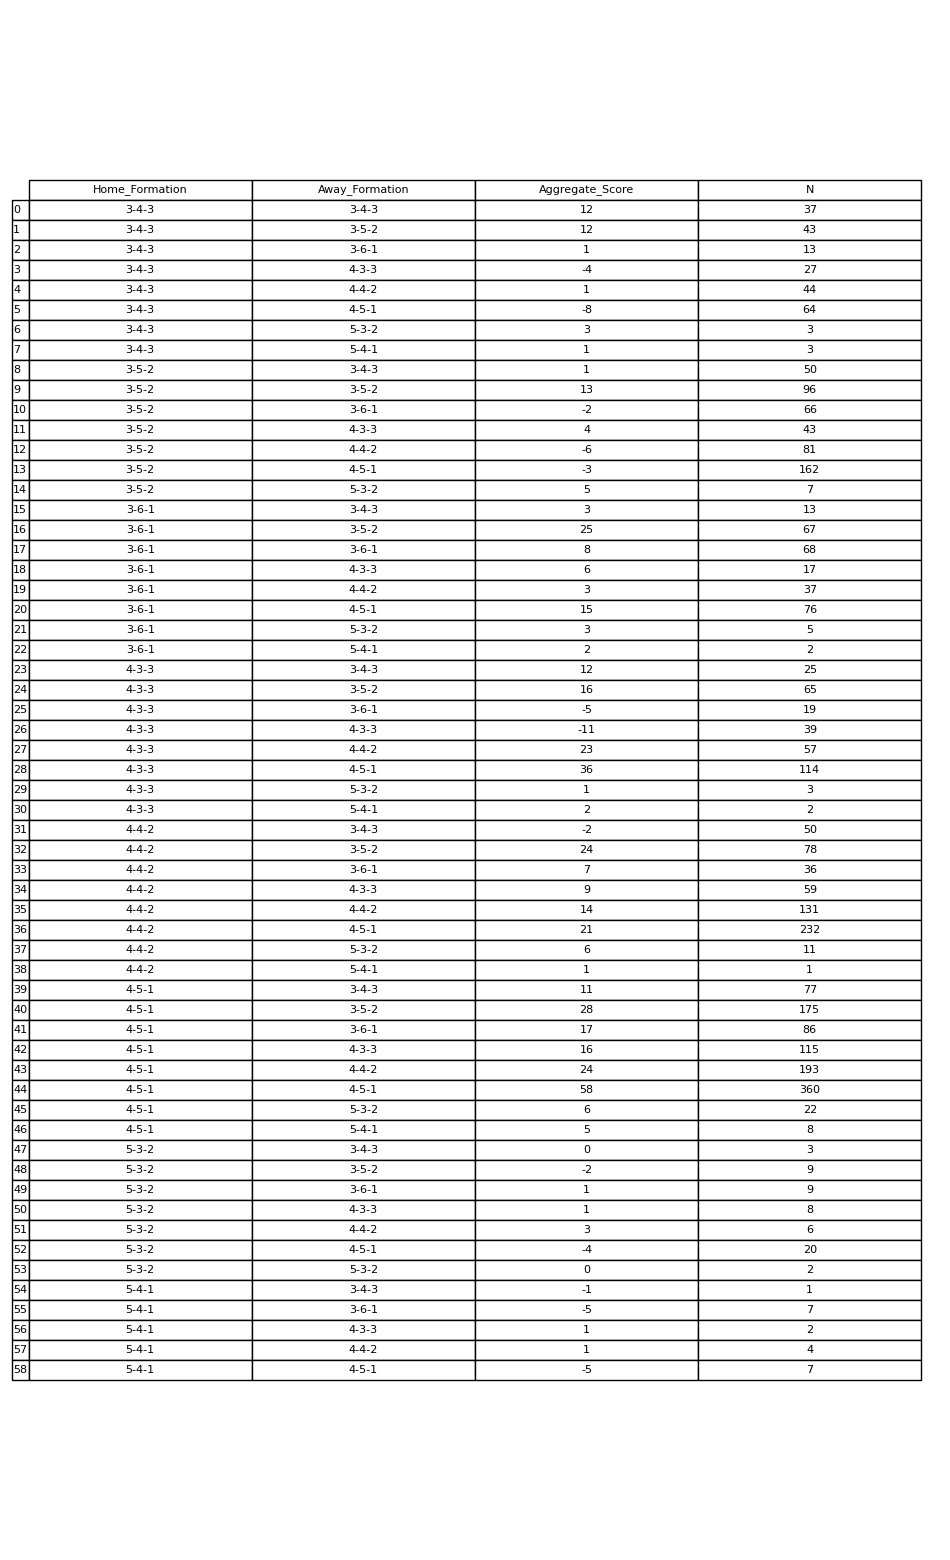

In [75]:
# Read the scores CSV file
df = pd.read_csv('bundesliga_formation_effectiveness_scores.csv')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 20))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')

# Create the table
tbl = table(ax, df, loc='center', cellLoc='center', colWidths=[0.2]*len(df.columns))

# Adjust table properties
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.2, 1.2)  # Adjust the scale as needed

# Save the table as an image
plt.savefig('formation_scores_table.png', dpi=300, bbox_inches='tight')
plt.show()

### HTML for the Market Value per Team 

In [76]:
def inspect_transfermarkt_html():
    """
    Inspects the Transfermarkt HTML to understand the structure
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
    }
    
    # Test with one specific season
    url = "https://www.transfermarkt.com/bundesliga/startseite/wettbewerb/L1/plus/?saison_id=2023"
    
    print("Getting HTML from Transfermarkt...")
    
    try:
        response = requests.get(url, headers=headers, timeout=15)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Save the full HTML for inspection
        with open('transfermarkt_debug.html', 'w', encoding='utf-8') as f:
            f.write(soup.prettify())
        print("✅ HTML saved as 'transfermarkt_debug.html'")
        
        # Search for different possible structures
        print("\nSearching for tables with teams...")
        
        # Option 1: Tables with class 'items'
        tables = soup.find_all('table', {'class': 'items'})
        print(f"'items' tables found: {len(tables)}")
        
        for i, table in enumerate(tables):
            print(f"\n--- Table {i+1} ---")
            rows = table.find_all('tr')
            print(f"Rows in table: {len(rows)}")
            
            # Show first 3 rows as example
            for j, row in enumerate(rows[:3]):
                print(f"Row {j+1}: {row.text[:100]}...")
        
        # Option 2: Search for text containing "Market value"
        print("\nSearching for elements containing 'Market value'...")
        market_value_elements = soup.find_all(text=re.compile('Market value', re.IGNORECASE))
        print(f"Elements with 'Market value': {len(market_value_elements)}")
        
        # Option 3: Search for team containers
        print("\nSearching for team links...")
        team_links = soup.find_all('a', href=re.compile(r'/startseite/verein/'))
        print(f"Team links found: {len(team_links)}")
        
        for i, link in enumerate(team_links[:5]):
            print(f"Team {i+1}: {link.text.strip()} -> {link.get('href')}")
            
    except Exception as e:
        print(f"❌ Error: {e}")

def find_correct_selectors():
    """
    Finds the correct selectors for the data
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    
    url = "https://www.transfermarkt.com/bundesliga/startseite/wettbewerb/L1/plus/?saison_id=2023"
    
    try:
        response = requests.get(url, headers=headers, timeout=15)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        print("🎯 ANALYZING DATA STRUCTURE...")
        
        # Find the main table
        table = soup.find('table', {'class': 'items'})
        
        if table:
            print("✅ Main table found")
            
            # Find team rows
            rows = table.find_all('tr', class_=['odd', 'even'])
            print(f"Team rows found: {len(rows)}")
            
            if rows:
                # Analyze first row in detail
                first_row = rows[0]
                print("\nANALYZING FIRST ROW:")
                
                # Find all cells
                cells = first_row.find_all('td')
                print(f"Cells in row: {len(cells)}")
                
                for i, cell in enumerate(cells):
                    print(f"Cell {i}: {cell.text.strip()}")
                
                # Look specifically for the team name
                team_cell = first_row.find('td', class_='hauptlink')
                if team_cell:
                    team_name = team_cell.find('a')
                    if team_name:
                        print(f"Team name: {team_name.text.strip()}")
                        print(f"Link: {team_name.get('href')}")
                
                # Look for market value
                value_cells = first_row.find_all('td', class_='rechts')
                for i, cell in enumerate(value_cells):
                    print(f"Right cell {i}: {cell.text.strip()}")
                
        else:
            print("❌ Main table not found")
            
    except Exception as e:
        print(f"❌ Error: {e}")

if __name__ == "__main__":
    print("=== DEBUG TRANSFERMARKT ===")
    inspect_transfermarkt_html()
    print("\n" + "="*50)
    find_correct_selectors()


=== DEBUG TRANSFERMARKT ===
Getting HTML from Transfermarkt...
✅ HTML saved as 'transfermarkt_debug.html'

Searching for tables with teams...
'items' tables found: 3

--- Table 1 ---
Rows in table: 20
Row 1: 
ClubnameSquadø ageForeignersø market valueTotal market value...
Row 2: 
  62826.0 Years318€7.80m€4.90bn...
Row 3: 
Bayern Munich 3925.223€24.75m€965.15m...

--- Table 2 ---
Rows in table: 19
Row 1: 
#Club +/-Pts...
Row 2: 
1  

Leverkusen
346590...
Row 3: 
2  

Stuttgart
343973...

--- Table 3 ---
Rows in table: 16
Row 1: 
#PlayerAgeClubGoals...
Row 2: 
1Harry KaneCentre-Forward3036...
Row 3: Harry Kane...

Searching for elements containing 'Market value'...
Elements with 'Market value': 8

Searching for team links...
Team links found: 43
Team 1: Bayern Munich -> /bayern-munich/startseite/verein/27
Team 2: Bayern Munich -> /bayern-munich/startseite/verein/27
Team 3:  -> /fc-bayern-munchen/startseite/verein/27/saison_id/2023
Team 4: Bayern Munich -> /fc-bayern-munchen/startseite/ve

/var/folders/j6/7fwvjzw13t11t4z5v8sd0lv80000gn/T/ipykernel_41553/3870845389.py:41: DeprecationWarning:

The 'text' argument to find()-type methods is deprecated. Use 'string' instead.



🎯 ANALYZING DATA STRUCTURE...
✅ Main table found
Team rows found: 18

ANALYZING FIRST ROW:
Cells in row: 7
Cell 0: 
Cell 1: Bayern Munich
Cell 2: 39
Cell 3: 25.2
Cell 4: 23
Cell 5: €24.75m
Cell 6: €965.15m
Team name: Bayern Munich
Link: /fc-bayern-munchen/startseite/verein/27/saison_id/2023
Right cell 0: €24.75m
Right cell 1: €965.15m


### Gets the Market Value Per Year of Each Team

In [ ]:
def get_market_values_simple():
    """
    Corrected version to obtain TOTAL MARKET VALUES
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'DNT': '1',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
        'Sec-Fetch-Dest': 'document',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-Site': 'none',
        'Cache-Control': 'max-age=0',
    }
    
    seasons = {
        "2015-2016": "2015",
        "2016-2017": "2016", 
        "2017-2018": "2017",
        "2018-2019": "2018",
        "2019-2020": "2019",
        "2020-2021": "2020",
        "2021-2022": "2021",
        "2022-2023": "2022",
        "2023-2024": "2023",
        "2024-2025": "2024"
    }
    
    all_data = []
    
    for season_name, season_id in seasons.items():
        print(f"🔍 Processing {season_name}...")
        
        url = f"https://www.transfermarkt.com/bundesliga/startseite/wettbewerb/L1/plus/?saison_id={season_id}"
        
        try:
            # Make the request
            response = requests.get(url, headers=headers, timeout=15)
            
            if response.status_code != 200:
                print(f"   ❌ HTTP Error {response.status_code} for {season_name}")
                continue
            
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # FIND THE CORRECT TABLE
            table = soup.find('table', {'class': 'items'})
            
            if not table:
                print(f"   ❌ No table found for {season_name}")
                continue
            
            # Find team rows
            rows = table.find_all('tr', class_=re.compile(r'(odd|even)'))
            
            if not rows:
                print(f"   No rows found in table for {season_name}")
                continue
            
            print(f"  Found {len(rows)} rows")
            
            season_teams = 0
            for row in rows:
                try:
                    # EXTRACT TEAM NAME
                    team_link = row.find('a', href=re.compile(r'/startseite/verein/'))
                    if not team_link:
                        continue
                    
                    team_name = team_link.get('title', '').strip()
                    if not team_name:
                        team_name = team_link.text.strip()
                    
                    if not team_name:
                        continue

                    # PRECISE STRATEGY: Use the exact index of "Total market value"
                    market_value = 0.0
                    
                    # "Total market value" is located at index 6
                    cells = row.find_all('td')
                    if len(cells) > 6:  # Index 6 = "Total market value"
                        value_cell = cells[6]
                        
                        # The value is inside an <a> tag
                        value_link = value_cell.find('a')
                        if value_link:
                            value_text = value_link.get_text(strip=True)
                        else:
                            value_text = value_cell.get_text(strip=True)
                        
                        if '€' in value_text:
                            market_value = parse_market_value(value_text)
                            # Additional validation: must be a large value (>100M for large clubs)
                            if market_value < 10:  # If too small, likely incorrect
                                print(f"   ⚠️ Suspiciously low value: {market_value}M €")
                    
                    # If not found in index 6, search by header text
                    if market_value == 0:
                        table_parent = row.find_parent('table', {'class': 'items'})
                        if table_parent:
                            headers_row = table_parent.find('thead')
                            if headers_row:
                                header_cells = headers_row.find_all('th')
                                for idx, header in enumerate(header_cells):
                                    header_text = header.get_text(strip=True)
                                    if 'Total market value' in header_text:
                                        if len(cells) > idx:
                                            value_cell = cells[idx]
                                            value_link = value_cell.find('a')
                                            if value_link:
                                                value_text = value_link.get_text(strip=True)
                                            else:
                                                value_text = value_cell.get_text(strip=True)
                                            
                                            if '€' in value_text:
                                                market_value = parse_market_value(value_text)
                                                break
                    
                    if market_value > 0:
                        all_data.append({
                            'season': season_name,
                            'team': team_name,
                            'total_market_value': market_value
                        })
                        season_teams += 1
                        print(f"   ✅ {team_name}: {market_value}M € (TOTAL)")
                    else:
                        print(f"   ⚠️ {team_name}: Total value not found")
                        
                except Exception as e:
                    print(f"   ❌ Error processing team: {e}")
                    continue
            
            print(f"    {season_name}: {season_teams} teams processed")
            
            # Wait between seasons
            if season_name != "2024-2025":
                wait_time = random.uniform(2, 4)
                time.sleep(wait_time)
                
        except Exception as e:
            print(f"   Error in {season_name}: {e}")
            continue
    
    return all_data

def parse_market_value(value_text):
    """
    Converts market value text into a numeric value
    """
    try:
        # Clean the text
        value_text = value_text.replace('€', '').replace(',', '').strip()
        
        # Extract numbers
        numbers = re.findall(r'[\d.]+', value_text)
        if not numbers:
            return 0.0
        
        number = float(numbers[0])
        
        # Detect unit — FIXED for total values which tend to be much larger
        if 'm' in value_text.lower():
            return number
        elif 'th.' in value_text.lower() or 'k' in value_text.lower():
            return number / 1000  # Convert thousands to millions
        else:
            # For values without unit: if >10, assume millions; else, thousands
            return number if number > 10 else number * 1000
            
    except Exception as e:
        print(f"      ⚠️ Error parsing '{value_text}': {e}")
        return 0.0

def save_single_csv(all_data):
    """
    Saves all data into a single CSV
    """
    if not all_data:
        print("❌ No data to save")
        return None
    
    df = pd.DataFrame(all_data)
    
    # Sort by season and value (descending)
    df = df.sort_values(['season', 'total_market_value'], ascending=[True, False])
    
    # Save file
    filename = 'market_values_total_all_seasons.csv'
    df.to_csv(filename, index=False, encoding='utf-8')
    
    print(f"\nFile saved: {filename}")
    print(f"Total records: {len(df)}")
    print(f"Seasons: {df['season'].nunique()}")
    print(f"Unique teams: {df['team'].nunique()}")
    
    # Show basic statistics
    print(f"\nTOTAL MARKET VALUE STATISTICS:")
    total_value_all_seasons = df['total_market_value'].sum()
    avg_value_per_team = df['total_market_value'].mean()
    max_value = df['total_market_value'].max()
    
    print(f"   Total accumulated value across seasons: {total_value_all_seasons:,.0f}M €")
    print(f"   Average value per team: {avg_value_per_team:.2f}M €")
    print(f"   Maximum recorded value: {max_value:.2f}M €")
    
    return df

def main():
    """
    Main function
    """
    print("=" * 60)
    print(" OBTAINING TOTAL MARKET VALUES – CORRECTED VERSION")
    print("=" * 60)
    
    # Get data
    print("\n Downloading data from Transfermarkt...")
    all_data = get_market_values_simple()
    
    # Save CSV
    if all_data:
        df = save_single_csv(all_data)
        
        # Show summary by season
        print(f"\nSEASON SUMMARY:")
        for season in sorted(df['season'].unique()):
            season_data = df[df['season'] == season]
            total_season_value = season_data['total_market_value'].sum()
            avg_season_value = season_data['total_market_value'].mean()
            max_season_value = season_data['total_market_value'].max()
            
            print(f"\n   {season}:")
            print(f"     Teams: {len(season_data)}")
            print(f"     Total season value: {total_season_value:,.0f}M €")
            print(f"     Average team value: {avg_season_value:.2f}M €")
            print(f"     Most valuable team: {season_data.iloc[0]['team']} ({max_season_value:.2f}M €)")
        
        # Top 5 most valuable teams (all seasons)
        print(f"\n🏆 TOP 5 MOST VALUABLE TEAMS (ALL SEASONS):")
        top_teams = df.nlargest(5, 'total_market_value')[['season', 'team', 'total_market_value']]
        for i, (_, row) in enumerate(top_teams.iterrows(), 1):
            print(f"   {i}. {row['team']} ({row['season']}): {row['total_market_value']:.2f}M €")
            
        # Check for suspiciously low values
        low_values = df[df['total_market_value'] < 10]  # <10M would be suspicious in Bundesliga
        if not low_values.empty:
            print(f"\n⚠️  WARNING: Found {len(low_values)} potentially incorrect values (< 10M €)")
            print("   This may indicate that average value was extracted instead of total value")
            
    else:
        print("❌ Failed to retrieve data")

if __name__ == "__main__":
    main()


🎯 OBTAINING TOTAL MARKET VALUES – CORRECTED VERSION

📥 Downloading data from Transfermarkt...
🔍 Processing 2015-2016...
  Found 18 rows
   ✅ Bayern Munich: 596.05M € (TOTAL)
   ✅ Borussia Dortmund: 352.95M € (TOTAL)
   ✅ VfL Wolfsburg: 270.43M € (TOTAL)
   ✅ Bayer 04 Leverkusen: 241.3M € (TOTAL)
   ✅ FC Schalke 04: 225.2M € (TOTAL)
   ✅ Borussia Mönchengladbach: 186.15M € (TOTAL)
   ✅ TSG 1899 Hoffenheim: 90.2M € (TOTAL)
   ✅ 1.FSV Mainz 05: 85.15M € (TOTAL)
   ✅ VfB Stuttgart: 81.18M € (TOTAL)
   ✅ Hertha BSC: 78.93M € (TOTAL)
   ✅ Eintracht Frankfurt: 76.6M € (TOTAL)
   ✅ FC Augsburg: 75.83M € (TOTAL)
   ✅ 1.FC Köln: 68.63M € (TOTAL)
   ✅ SV Werder Bremen: 64.68M € (TOTAL)
   ✅ Hamburger SV: 63.2M € (TOTAL)
   ✅ Hannover 96: 60.83M € (TOTAL)
   ✅ FC Ingolstadt 04: 35.65M € (TOTAL)
   ✅ SV Darmstadt 98: 25.15M € (TOTAL)
   🎯 2015-2016: 18 teams processed
🔍 Processing 2016-2017...
  Found 18 rows
   ✅ Bayern Munich: 562.55M € (TOTAL)
   ✅ Borussia Dortmund: 390.65M € (TOTAL)
   ✅ Bayer

### Season 2017-2018 and 2020-2021 were not scraped on the first attempt, so it was scraped individually
On the final review (11.12.2025) all seasons with the value were scraped. But I leave the code below just in case it does not work in further analysis or executions. 
The key is to change the sesons for the ones you were missing data and run the code.

In [77]:
def get_market_values_2017_2020():
    """
    Gets market values for seasons 2017-2018 and 2020-2021
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'DNT': '1',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
        'Sec-Fetch-Dest': 'document',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-Site': 'none',
        'Cache-Control': 'max-age=0',
    }
    
    seasons = {
        "2017-2018": "2017",
        "2020-2021": "2021"
    }
    
    all_data = []
    
    for season_name, season_id in seasons.items():
        print(f"🔍 Processing {season_name}...")
        
        url = f"https://www.transfermarkt.com/bundesliga/startseite/wettbewerb/L1/plus/?saison_id={season_id}"
        
        max_retries = 3
        retry_delay = 5
        
        for attempt in range(max_retries):
            try:
                print(f"   Attempt {attempt + 1}/{max_retries}...")
                
                # Make the request with a longer timeout
                response = requests.get(url, headers=headers, timeout=30)
                
                if response.status_code != 200:
                    print(f"   ❌ HTTP error {response.status_code} for {season_name}")
                    if attempt < max_retries - 1:
                        time.sleep(retry_delay)
                        continue
                    else:
                        break
                
                soup = BeautifulSoup(response.content, 'html.parser')
                
                # FIND THE CORRECT TABLE
                table = soup.find('table', {'class': 'items'})
                
                if not table:
                    print(f"   ❌ No table found for {season_name}")
                    break
                
                # Find team rows
                rows = table.find_all('tr', class_=re.compile(r'(odd|even)'))
                
                if not rows:
                    print(f"   ⚠️ No rows found in table for {season_name}")
                    break
                
                print(f"   📊 Found {len(rows)} rows")
                
                season_teams = 0
                for row in rows:
                    try:
                        # EXTRACT TEAM NAME
                        team_link = row.find('a', href=re.compile(r'/startseite/verein/'))
                        if not team_link:
                            continue
                        
                        team_name = team_link.get('title', '').strip()
                        if not team_name:
                            team_name = team_link.text.strip()
                        
                        if not team_name:
                            continue

                        # PRECISE STRATEGY: Use the exact index of "Total market value"
                        market_value = 0.0
                        
                        # The "Total market value" column is at index 6
                        cells = row.find_all('td')
                        if len(cells) > 6:  # Index 6 = "Total market value"
                            value_cell = cells[6]
                            
                            # The value is inside an <a> tag
                            value_link = value_cell.find('a')
                            if value_link:
                                value_text = value_link.get_text(strip=True)
                            else:
                                value_text = value_cell.get_text(strip=True)
                            
                            if '€' in value_text:
                                market_value = parse_market_value(value_text)
                                # Extra validation: should be a large value (>100M for big teams)
                                if market_value < 10:  # If very small, could be an error
                                    print(f"   ⚠️  Suspiciously low value: {market_value}M €")
                        
                        # If for some reason it's not at index 6, search by header
                        if market_value == 0:
                            table_parent = row.find_parent('table', {'class': 'items'})
                            if table_parent:
                                headers_row = table_parent.find('thead')
                                if headers_row:
                                    header_cells = headers_row.find_all('th')
                                    for idx, header in enumerate(header_cells):
                                        header_text = header.get_text(strip=True)
                                        if 'Total market value' in header_text:
                                            if len(cells) > idx:
                                                value_cell = cells[idx]
                                                value_link = value_cell.find('a')
                                                if value_link:
                                                    value_text = value_link.get_text(strip=True)
                                                else:
                                                    value_text = value_cell.get_text(strip=True)
                                                
                                                if '€' in value_text:
                                                    market_value = parse_market_value(value_text)
                                                    break
                        
                        if market_value > 0:
                            all_data.append({
                                'season': season_name,
                                'team': team_name,
                                'total_market_value': market_value
                            })
                            season_teams += 1
                            print(f"   ✅ {team_name}: {market_value}M € (TOTAL)")
                        else:
                            print(f"   ⚠️ {team_name}: Total value not found")
                            
                    except Exception as e:
                        print(f"   ❌ Error processing team: {e}")
                        continue
                
                print(f"   🎯 {season_name}: {season_teams} teams processed")
                break  # Exit retry loop if successful
                    
            except requests.exceptions.Timeout:
                print(f"   ⏰ Timeout on attempt {attempt + 1}")
                if attempt < max_retries - 1:
                    print(f"   ⏳ Waiting {retry_delay} seconds before retrying...")
                    time.sleep(retry_delay)
                    retry_delay *= 2  # Exponential backoff
                else:
                    print("   ❌ All retry attempts failed due to timeout")
                    
            except Exception as e:
                print(f"   🔌 Error in {season_name}: {e}")
                if attempt < max_retries - 1:
                    time.sleep(retry_delay)
                else:
                    break
        
        # Wait between seasons
        if season_name != "2020-2021":
            wait_time = random.uniform(3, 6)
            print(f"   ⏳ Waiting {wait_time:.1f} seconds before the next season...")
            time.sleep(wait_time)
    
    return all_data

def parse_market_value(value_text):
    """
    Converts market value text into a numeric value
    """
    try:
        # Clean the text
        value_text = value_text.replace('€', '').replace(',', '').strip()
        
        # Find numbers
        numbers = re.findall(r'[\d.]+', value_text)
        if not numbers:
            return 0.0
        
        number = float(numbers[0])
        
        # Determine unit – FIXED for total values that tend to be larger
        if 'm' in value_text.lower():
            return number
        elif 'th.' in value_text.lower() or 'k' in value_text.lower():
            return number / 1000  # Convert thousands to millions
        else:
            # For values without suffix: if the number is large (>10) assume millions, otherwise thousands
            return number if number > 10 else number * 1000
            
    except Exception as e:
        print(f"      ⚠️ Error parsing '{value_text}': {e}")
        return 0.0

def save_missing_seasons(all_data):
    """
    Saves the data for the missing seasons
    """
    if not all_data:
        print("❌ No data to save")
        return None
    
    df = pd.DataFrame(all_data)
    
    # Sort by season and value (descending)
    df = df.sort_values(['season', 'total_market_value'], ascending=[True, False])
    
    # Save
    filename = 'market_values_2017_2020.csv'
    df.to_csv(filename, index=False, encoding='utf-8')
    
    print(f"\n💾 File saved: {filename}")
    print(f"📊 Total records: {len(df)}")
    print(f"📅 Seasons: {df['season'].nunique()}")
    
    # Show statistics by season
    print(f"\n📈 SEASON STATISTICS:")
    for season in sorted(df['season'].unique()):
        season_data = df[df['season'] == season]
        total_value = season_data['total_market_value'].sum()
        avg_value = season_data['total_market_value'].mean()
        max_value = season_data['total_market_value'].max()
        min_value = season_data['total_market_value'].min()
        
        print(f"\n   {season}:")
        print(f"     Teams: {len(season_data)}")
        print(f"     Total value: {total_value:,.0f}M €")
        print(f"     Average value: {avg_value:.2f}M €")
        print(f"     Maximum value: {max_value:.2f}M €")
        print(f"     Minimum value: {min_value:.2f}M €")
        print(f"     Most valuable team: {season_data.iloc[0]['team']}")
    
    return df


### Merging all the data into a single csv file to have all the team's values of all the years (2015-2025)

In [78]:
# Load files
df1 = pd.read_csv('market_values_2017_2020.csv')
df2 = pd.read_csv('market_values_total_all_seasons.csv')

# Remove duplicate seasons from the full dataset
df2_clean = df2[~df2['season'].isin(['2017-2018', '2020-2021'])]

# Merge files
df_merged = pd.concat([df2_clean, df1], ignore_index=True)

# Sort by season and market value
df_merged = df_merged.sort_values(['season', 'total_market_value'], ascending=[True, False])

# Save result
df_merged.to_csv('market_values_merged.csv', index=False)

print(f"✅ Merged file created: {len(df_merged)} records")
print(f"📅 Seasons included: {sorted(df_merged['season'].unique())}")


✅ Merged file created: 180 records
📅 Seasons included: ['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']


### To detect differences in the name of the teams of both data sets

In [79]:
# Load files
matches = pd.read_csv('bundesliga_matches_merged.csv')
market_values = pd.read_csv('market_values_merged.csv')

# Get unique teams per season from each dataset
matches_teams = matches.groupby('season').apply(
    lambda x: set(x['home_team']).union(set(x['away_team']))
).to_dict()

market_teams = market_values.groupby('season')['team'].apply(set).to_dict()

# Compare season by season
for season in sorted(set(matches_teams.keys()).intersection(set(market_teams.keys()))):
    diff_matches = matches_teams[season] - market_teams[season]
    diff_market = market_teams[season] - matches_teams[season]
    
    if diff_matches or diff_market:
        print(f"\n🔍 {season}:")
        if diff_matches:
            print(f"   ❌ Only in matches: {list(diff_matches)}")
        if diff_market:
            print(f"   ❌ Only in market values: {list(diff_market)}")
    else:
        print(f"✅ {season}: Teams match")

print(f"\n Summary: {len(matches_teams)} match seasons, {len(market_teams)} market-value seasons")



🔍 2015-2016:
   ❌ Only in matches: ['Bayern München', '1. FC Köln', '1. FSV Mainz 05', 'Werder Bremen', 'Bayer Leverkusen', '1899 Hoffenheim']
   ❌ Only in market values: ['Bayer 04 Leverkusen', 'SV Werder Bremen', '1.FC Köln', 'TSG 1899 Hoffenheim', '1.FSV Mainz 05', 'Bayern Munich']

🔍 2016-2017:
   ❌ Only in matches: ['Bayern München', '1. FC Köln', '1. FSV Mainz 05', 'Werder Bremen', 'Bayer Leverkusen', '1899 Hoffenheim']
   ❌ Only in market values: ['Bayer 04 Leverkusen', 'SV Werder Bremen', '1.FC Köln', 'TSG 1899 Hoffenheim', '1.FSV Mainz 05', 'Bayern Munich']

🔍 2017-2018:
   ❌ Only in matches: ['Bayern München', '1. FC Köln', '1. FSV Mainz 05', 'Werder Bremen', 'Bayer Leverkusen', '1899 Hoffenheim']
   ❌ Only in market values: ['Bayer 04 Leverkusen', 'SV Werder Bremen', '1.FC Köln', 'TSG 1899 Hoffenheim', '1.FSV Mainz 05', 'Bayern Munich']

🔍 2018-2019:
   ❌ Only in matches: ['1. FC Nürnberg', 'Bayern München', '1. FSV Mainz 05', 'Werder Bremen', 'Bayer Leverkusen', '1899 Hoff

/var/folders/j6/7fwvjzw13t11t4z5v8sd0lv80000gn/T/ipykernel_41553/140729730.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [80]:
# Load files
matches = pd.read_csv('bundesliga_matches_merged.csv')
market_values = pd.read_csv('market_values_merged.csv')

# Merge market values for home teams
matches = matches.merge(
    market_values,
    left_on=['season', 'home_team'],
    right_on=['season', 'team'],
    how='left'
).rename(columns={'total_market_value': 'home_team_market_value'}).drop('team', axis=1)

# Merge market values for away teams
matches = matches.merge(
    market_values,
    left_on=['season', 'away_team'],
    right_on=['season', 'team'],
    how='left'
).rename(columns={'total_market_value': 'away_team_market_value'}).drop('team', axis=1)

# Save final file
matches.to_csv('bundesliga_matches_with_market_values.csv', index=False)

print(f"✅ Merged file created: {len(matches)} matches")
print(f"Added columns: home_team_market_value, away_team_market_value")


✅ Merged file created: 3060 matches
Added columns: home_team_market_value, away_team_market_value


### A problem regarding differences in the names of both files is detected, so is proceeded to get the names of the base file

In [81]:
# Load matches file
matches = pd.read_csv('bundesliga_matches_merged.csv')

# Get unique team names per season
home_teams = matches[['season', 'home_team']].rename(columns={'home_team': 'team'})
away_teams = matches[['season', 'away_team']].rename(columns={'away_team': 'team'})
all_teams = pd.concat([home_teams, away_teams]).drop_duplicates()

# Sort by season and team
all_teams = all_teams.sort_values(['season', 'team']).reset_index(drop=True)

# Save file
all_teams.to_csv('names_per_season.csv', index=False)

print(f"✅ File saved: names_per_season.csv")
print(f" {len(all_teams)} records — {all_teams['season'].nunique()} seasons")


✅ File saved: names_per_season.csv
 180 records — 10 seasons


### A new document is created with the same names as the base file. 

In [82]:
# Read files
base = pd.read_csv('bundesliga_matches_merged.csv')
valores = pd.read_csv('market_values_merged.csv')

# Create dictionary for name mapping
name_mapping = {
    'Bayern Munich': 'Bayern München',
    'Bayer 04 Leverkusen': 'Bayer Leverkusen', 
    'TSG 1899 Hoffenheim': '1899 Hoffenheim',
    '1.FSV Mainz 05': '1. FSV Mainz 05',
    '1.FC Köln': '1. FC Köln',
    'SV Werder Bremen': 'Werder Bremen',
    '1.FC Nuremberg': '1. FC Nürnberg',
    '1.FC Union Berlin': '1. FC Union Berlin',
    'SC Paderborn 07': 'SC Paderborn 07',
    'Arminia Bielefeld': 'Arminia Bielefeld',
    'VfL Bochum': 'VfL Bochum',
    'SpVgg Greuther Fürth': 'SpVgg Greuther Fürth',
    '1.FC Heidenheim 1846': '1. FC Heidenheim 1846',
    'FC St. Pauli': 'FC St. Pauli',
    'Holstein Kiel': 'Holstein Kiel'
}

# Apply mapping and save
valores['team'] = valores['team'].replace(name_mapping)
valores.to_csv('market_values_final.csv', index=False)


### Unite all the data with the value of each team

In [83]:
# Read files
matches = pd.read_csv('bundesliga_matches_merged.csv')
values = pd.read_csv('market_values_final.csv')

# Merge for home_team
merged = matches.merge(
    values, 
    how='left', 
    left_on=['season', 'home_team'], 
    right_on=['season', 'team']
)
merged = merged.rename(columns={'value': 'total_market_value_home'}).drop('team', axis=1)

# Merge for away_team
merged = merged.merge(
    values, 
    how='left', 
    left_on=['season', 'away_team'], 
    right_on=['season', 'team']
)
merged = merged.rename(columns={'value': 'total_market_value_away'}).drop('team', axis=1)

# Check number of rows
print(f"Number of matches after merge: {len(merged)}")

# Save result
merged.to_csv('bundesliga_values_complete.csv', index=False)


Number of matches after merge: 3060


In [85]:
# Fixing column names in a new cell
# Read the recently created file
merged = pd.read_csv('bundesliga_values_complete.csv')

# Rename columns if they exist
if 'total_market_value_x' in merged.columns and 'total_market_value_y' in merged.columns:
    merged = merged.rename(columns={
        'total_market_value_x': 'total_market_value_home',
        'total_market_value_y': 'total_market_value_away'
    })
    print("Columns renamed successfully")
else:
    print("Columns already have the correct names or do not exist")

# Save again with corrected column names
merged.to_csv('bundesliga_values_complete.csv', index=False)
print("File saved with corrected column names")

# Display first rows to verify
print(merged.head())


Columns renamed successfully
File saved with corrected column names
      season     matchday        home_team         away_team  home_score  \
0  2015-2016  1. Spieltag   Bayern München      Hamburger SV           5   
1  2015-2016  1. Spieltag  1. FSV Mainz 05  FC Ingolstadt 04           0   
2  2015-2016  1. Spieltag  SV Darmstadt 98       Hannover 96           2   
3  2015-2016  1. Spieltag    Werder Bremen     FC Schalke 04           0   
4  2015-2016  1. Spieltag      FC Augsburg        Hertha BSC           0   

   away_score home_formation away_formation  total_market_value_home  \
0           0          4-5-1          4-3-3                   596.05   
1           1          4-5-1          4-3-3                    85.15   
2           2          4-4-2          4-5-1                    25.15   
3           3          4-4-2          4-4-2                    64.68   
4           1          4-5-1          4-5-1                    75.83   

   total_market_value_away  
0            

0. Add an additional column called "group_zone" and divide teams into groups ("group_1" = the 6 most valuable teams per season, "group_2" from 7th to 12th in value, and "group_3" from 13th to 18th in value per season)
1. Consider the result (home_score, away_score)
2. Consider the team values (total_market_value_home, total_market_value_away)
3. If the result is a draw and both teams are in the same group_zone, then delete that row.
4. Delete the row if a team from a superior group_zone wins against a team from an inferior group_zone
5. If the team from an inferior group_zone ties or wins against a team from a superior group_zone, then it's a surprise and you keep the game.
6. Delete also the ties between teams of the same group (example group_1 vs group1 1-1, delete the row)



In [86]:
# Read the complete dataset
df = pd.read_csv('bundesliga_values_complete.csv')

# Create team rankings and group zones for each season
val_df = df[['season','home_team','total_market_value_home']].rename(
    columns={'home_team':'team','total_market_value_home':'value'}).drop_duplicates()
val_df['rank'] = val_df.groupby('season')['value'].rank(ascending=False)
val_df['group_zone'] = pd.cut(val_df['rank'], bins=[0,6,12,18], 
                             labels=['group_1','group_2','group_3'])

# Merge group zones for home and away teams
df = df.merge(val_df[['season','team','group_zone']], 
             left_on=['season','home_team'], 
             right_on=['season','team']).rename(columns={'group_zone':'home_zone'}).drop(columns=['team'])
df = df.merge(val_df[['season','team','group_zone']], 
             left_on=['season','away_team'], 
             right_on=['season','team']).rename(columns={'group_zone':'away_zone'}).drop(columns=['team'])

# Apply filtering conditions
# Keep only surprises: inferior teams tying or winning against superior teams
df = df[~((df.home_score == df.away_score) & (df.home_zone == df.away_zone) | 
          ((df.home_zone < df.away_zone) & (df.home_score > df.away_score)) | 
          ((df.away_zone < df.home_zone) & (df.away_score > df.home_score)))]

# Verify results
print(f"Total games before filtering: {len(pd.read_csv('bundesliga_values_complete.csv'))}")
print(f"Surprise games after filtering: {len(df)}")

# Save the result
df.to_csv('bundesliga_surprises.csv', index=False)
print("Surprise games saved to bundesliga_surprises.csv")

Total games before filtering: 3060
Surprise games after filtering: 1683
Surprise games saved to bundesliga_surprises.csv


### I am doing this recurrently in the code, to convert the csv files to excel files.

In [35]:
df = pd.read_csv('bundesliga_surprises.csv')
df = df.astype(str)  # Convert all to text to avoid Excel issues
df.to_excel("bundesliga_surprises.xlsx", index=False, engine='openpyxl')

### The following code gets the analysis of the effectiveness of the formation wich had surprises

In [ ]:
# Read surprise games
df = pd.read_csv('bundesliga_surprises.csv')
df = df[(df['home_formation'] != 'N/A') & (df['away_formation'] != 'N/A')]

# Analyze formation effectiveness
results = defaultdict(lambda: defaultdict(lambda: [0, 0, 0]))
for _, match in df.iterrows():
    hf, af = match['home_formation'], match['away_formation']
    if match['home_score'] > match['away_score']:
        results[hf][af][0] += 1
    elif match['home_score'] == match['away_score']:
        results[hf][af][1] += 1
    else:
        results[hf][af][2] += 1

# Create matrix
formations = sorted(set(df['home_formation'].unique()) | set(df['away_formation'].unique()))
matrix_data = [[f"{results[hf][af][0]}-{results[hf][af][1]}-{results[hf][af][2]}" if hf in results and af in results[hf] else "0-0-0" for af in formations] for hf in formations]

# Save result
pd.DataFrame(matrix_data, index=formations, columns=formations).to_csv('bundesliga_effectiveness_surprises.csv')
print("Effectiveness matrix for surprise games saved!")

Effectiveness matrix for surprise games saved!


In [ ]:
# Read the CSV file of the matrix
df = pd.read_csv('bundesliga_effectiveness_surprises.csv', index_col=0)

# Create a list to store the data in long (vertical) format
data = []

# Iterate over home formations (indices) and away formations (columns)
for home in df.index:
    for away in df.columns:
        result_str = df.loc[home, away]
        if result_str != '0-0-0':  # Skip entries with no results
            wins, draws, losses = map(int, result_str.split('-'))
            
            # Aggregate metrics (same logic as your given code)
            aggregate_score = wins - losses   # +1 for win, -1 for loss
            n = wins + draws + losses          # total observations
            
            data.append({
                'Home_Formation': home,
                'Away_Formation': away,
                'Wins': wins,
                'Draws': draws,
                'Losses': losses,
                'Aggregate_Score': aggregate_score,
                'N': n
            })

# Create a new DataFrame in vertical format
long_df = pd.DataFrame(data)

# Calculate total N for all formation pairs
total_n = long_df['N'].sum()

# Add a summary row with the total count
summary_row = pd.DataFrame({
    'Home_Formation': ['TOTAL'],
    'Away_Formation': ['ALL_FORMATIONS'],
    'Wins': [long_df['Wins'].sum()],
    'Draws': [long_df['Draws'].sum()],
    'Losses': [long_df['Losses'].sum()],
    'Aggregate_Score': [long_df['Aggregate_Score'].sum()],
    'N': [total_n]
})

# Concatenate the original dataframe with the summary row
long_df_with_total = pd.concat([long_df, summary_row], ignore_index=True)

# Save the result into a new CSV file
long_df_with_total.to_csv('bundesliga_effectiveness_surprises_vertical.csv', index=False)

# Show confirmation and preview
print("Vertical file saved as 'bundesliga_effectiveness_surprises_vertical.csv'")
print(f"Formation pairs: {len(long_df)}")
print(f"Total N (all matches): {total_n}")
print("\nFirst 5 rows of the vertical file:")
print(long_df.head())
print("\nLast row (summary):")
print(long_df_with_total.tail(1))

### Transform the csv files into Excel Files that can be read independently of the region

In [87]:
for file in [
    'bundesliga_effectiveness_surprises.csv',
    'bundesliga_effectiveness_surprises_vertical.csv'
]:
    df = pd.read_csv(file).astype(str)  # Convert everything to text
    df.to_excel(file.replace('.csv', '.xlsx'), index=False, engine='openpyxl')

print("✅ Conversion complete: both Excel files saved successfully.")


✅ Conversion complete: both Excel files saved successfully.


## Compute variance and standard deviation metrics for all formation pairings
### Generate five data files:

### 1. Formation variance matrix
Shows how much point outcomes vary for each formation (Higher variance = more unpredictable results)
### 2. Standard deviation matrix across tactical matchups
Measures consistency of points in each tactical matchup (Lower SD = more reliable performance)
### 3. Mean performance points matrix (contextual reference)
Displays average points earned per game between formations (identifies most effective tactical combinations)
### 4. Sample size matrix (N values)
Counts how many matches occurred for each formation pairing (shows data reliability - avoid small samples)
### 5. Aggregate formation performance statistics
Summarizes overall performance for each formation (total matches, avg points, variance, win rate) across all opponents

This one has a Edge Case handling, which does not include analysis of home_formation vs away_formation with few matches. But i think lacks of something.

In [88]:
# Read data and calculate metrics
df = pd.read_csv('bundesliga_effectiveness_surprises_vertical.csv')

def quick_metrics(row):
    # Scoring system: +1 for win, 0 for draw, -1 for loss
    scores = [1] * row['Wins'] + [0] * row['Draws'] + [-1] * row['Losses']
    n = len(scores)
    
    if n > 0:
        avg = np.mean(scores)  # Equivalent to Aggregate_Score / N
        var = np.var(scores, ddof=1) if n > 1 else 0
        std = np.std(scores, ddof=1) if n > 1 else 0
    else:
        avg = var = std = 0
    
    return avg, var, std

# Apply function to compute metrics
df[['Average_Score', 'Variance', 'Std_Dev']] = df.apply(
    lambda row: quick_metrics(row), axis=1, result_type='expand'
)
df[['Average_Score', 'Variance', 'Std_Dev']] = df[['Average_Score', 'Variance', 'Std_Dev']].round(3)

# Add data quality classification
df['Data_Quality'] = df['N'].apply(lambda x: 'High' if x >= 15 else 'Medium' if x >= 10 else 'Low')

# Save to new file
df.to_csv('bundesliga_var_sd_surprises.csv', index=False)

# Display results
print("✅ bundesliga_var_sd_surprises.csv created successfully!")
print(f" Total formation pairs: {len(df)}")

print("\n First 5 rows:")
print(df[['Home_Formation', 'Away_Formation', 'N', 'Average_Score', 'Variance', 'Std_Dev', 'Data_Quality']].head())

# Additional analysis by data quality
print(f"\n DATA QUALITY BREAKDOWN:")
quality_counts = df['Data_Quality'].value_counts()
for quality, count in quality_counts.items():
    n_for_quality = df[df['Data_Quality'] == quality]['N'].sum()
    print(f"   - {quality}: {count} pairs, {n_for_quality} matches")


✅ bundesliga_var_sd_surprises.csv created successfully!
 Total formation pairs: 55

 First 5 rows:
  Home_Formation Away_Formation   N  Average_Score  Variance  Std_Dev  \
0          3-4-3          3-4-3  13          0.462     0.603    0.776   
1          3-4-3          3-5-2  29          0.276     0.707    0.841   
2          3-4-3          3-6-1   8          0.000     0.571    0.756   
3          3-4-3          4-3-3  16         -0.062     0.729    0.854   
4          3-4-3          4-4-2  24          0.208     0.607    0.779   

  Data_Quality  
0       Medium  
1         High  
2          Low  
3         High  
4         High  

 DATA QUALITY BREAKDOWN:
   - High: 32 pairs, 3251 matches
   - Low: 20 pairs, 79 matches
   - Medium: 3 pairs, 36 matches


### Var and Std_Dev All Data

In [89]:
df = pd.read_csv('bundesliga_formation_effectiveness_vertical.csv')

def calculate_metrics(row):
    wins = row['Wins']
    draws = row['Draws']
    losses = row['Losses']
    
    # Calculate Aggregate_Score (Wins*1 + Draws*0 + Losses*-1)
    aggregate_score = wins - losses
    
    # Calculate N (total matches)
    n = wins + draws + losses
    
    # Calculate Average_Score (Aggregate_Score / N)
    avg_score = aggregate_score / n if n > 0 else 0
    
    # Calculate variance based on the average_score
    if n > 1:
        # Sum of squared deviations
        sum_squared_deviations = (
            wins * (1 - avg_score)**2 +
            draws * (0 - avg_score)**2 +
            losses * (-1 - avg_score)**2
        )
        variance = sum_squared_deviations / (n - 1)  # Sample variance (ddof=1)
        std_dev = np.sqrt(variance)
    elif n == 1:
        variance = 0
        std_dev = 0
    else:
        variance = std_dev = 0
    
    return pd.Series({
        'Aggregate_Score': aggregate_score,
        'N': n,
        'Average_Score': round(avg_score, 3),
        'Variance': round(variance, 3),
        'Std_Dev': round(std_dev, 3)
    })

# Apply the function to compute all metrics
metrics_df = df.apply(calculate_metrics, axis=1)

# Combine with the original DataFrame
result_df = pd.concat([df, metrics_df], axis=1)

# Create Data_Quality column based on N
result_df['Data_Quality'] = result_df['N'].apply(
    lambda x: 'High' if x >= 15 else 'Medium' if x >= 10 else 'Low'
)

# Define final column order
final_columns = [
    'Home_Formation', 'Away_Formation', 'Wins', 'Draws', 'Losses',
    'Aggregate_Score', 'N', 'Average_Score', 'Variance', 'Std_Dev', 'Data_Quality'
]

# Select columns in desired order
final_df = result_df[final_columns]

# Create a totals row at the end
total_wins = final_df['Wins'].sum()
total_draws = final_df['Draws'].sum()
total_losses = final_df['Losses'].sum()
total_n = final_df['N'].sum()
total_aggregate_score = final_df['Aggregate_Score'].sum()

# Totals row
total_row = pd.DataFrame({
    'Home_Formation': ['TOTAL'],
    'Away_Formation': ['ALL_FORMATIONS'],
    'Wins': [total_wins],
    'Draws': [total_draws],
    'Losses': [total_losses],
    'Aggregate_Score': [total_aggregate_score],
    'N': [total_n],
    'Average_Score': [round(total_aggregate_score / total_n, 4) if total_n > 0 else 0],
    'Variance': [np.nan],  # Variance not computed for total row
    'Std_Dev': [np.nan],   # Std Dev not computed for total row
    'Data_Quality': ['']
})

# Concatenate totals row
final_df_with_totals = pd.concat([final_df, total_row], ignore_index=True)

# Save result
final_df_with_totals.to_csv('bundesliga_var_sd_all_matches.csv', index=False)

print(f"✅ File saved: bundesliga_var_sd_all_matches.csv")
print(f"Total formation matchups analyzed: {len(final_df)}")
print(f"Data quality breakdown:")
print(f"   - High (N ≥ 15): {len(final_df[final_df['Data_Quality'] == 'High'])}")
print(f"   - Medium (N = 10–14): {len(final_df[final_df['Data_Quality'] == 'Medium'])}")
print(f"   - Low (N < 10): {len(final_df[final_df['Data_Quality'] == 'Low'])}")

# Display summary statistics
print(f"\nSummary statistics:")
print(f"   - Total matches analyzed: {total_n}")
print(f"   - Total wins: {total_wins}")
print(f"   - Total draws: {total_draws}")
print(f"   - Total losses: {total_losses}")
print(f"   - Total Aggregate_Score: {total_aggregate_score}")
print(f"   - Overall Average_Score: {total_aggregate_score / total_n:.4f}")

# Show first rows and last row
print("\nFirst 5 rows:")
print(final_df_with_totals.head())
print("\nLast row (TOTAL):")
print(final_df_with_totals.tail(1))


✅ File saved: bundesliga_var_sd_all_matches.csv
Total formation matchups analyzed: 59
Data quality breakdown:
   - High (N ≥ 15): 36
   - Medium (N = 10–14): 3
   - Low (N < 10): 20

Summary statistics:
   - Total matches analyzed: 3060.0
   - Total wins: 1354
   - Total draws: 756
   - Total losses: 950
   - Total Aggregate_Score: 404.0
   - Overall Average_Score: 0.1320

First 5 rows:
  Home_Formation Away_Formation  Wins  Draws  Losses  Aggregate_Score     N  \
0          3-4-3          3-4-3    21      7       9             12.0  37.0   
1          3-4-3          3-5-2    23      9      11             12.0  43.0   
2          3-4-3          3-6-1     5      4       4              1.0  13.0   
3          3-4-3          4-3-3     8      7      12             -4.0  27.0   
4          3-4-3          4-4-2    16     13      15              1.0  44.0   

   Average_Score  Variance  Std_Dev Data_Quality  
0          0.324     0.725    0.852         High  
1          0.279     0.730    0.8

### Var y SD en Excel

In [ ]:

# Convert CSV files to Excel
for file in [
    'bundesliga_var_sd_surprises.csv',
    'bundesliga_var_sd_all_matches.csv'
]:
    df = pd.read_csv(file).astype(str)  # Convertir todo a texto
    df.to_excel(file.replace('.csv', '.xlsx'), index=False, engine='openpyxl')

print("✅ Conversion complete: both Excel files saved successfully.")
print("Files created:")
print("   - bundesliga_var_sd_surprises.xlsx")
print("   - bundesliga_var_sd_all_matches.xlsx")

✅ Conversion complete: both Excel files saved successfully.
Files created:
   - bundesliga_var_sd_surprises.xlsx
   - bundesliga_var_sd_all_matches.xlsx


### Matrix Variance and Std Dev All Formations and Surprises

#### 25.11.25

In [ ]:
# Read the processed data file
df = pd.read_csv('bundesliga_var_sd_all_matches.csv')

# Filter out the total row and any ALL_FORMATIONS
df = df[~df['Home_Formation'].isin(['TOTAL'])]
df = df[~df['Away_Formation'].isin(['ALL_FORMATIONS'])]

# Create a combined string for Variance and Std_Dev
df['Variance_Std_Dev'] = df['Variance'].astype(str) + ", " + df['Std_Dev'].astype(str)

# Pivot to create the matrix with Home_Formation as rows and Away_Formation as columns
matrix = df.pivot(index='Home_Formation', columns='Away_Formation', values='Variance_Std_Dev')

# Fill NaN values with "0, 0" for formation matchups with no data
matrix = matrix.fillna("0, 0")

# Save the matrix to CSV
matrix.to_csv('bundesliga_var_sd_all_matches_matrix.csv')

print("✅ bundesliga_var_sd_all_matches_matrix.csv created successfully!")
print(f"Matrix shape: {matrix.shape}")
print(f"Home formations: {len(matrix.index)}")
print(f"Away formations: {len(matrix.columns)}")

# Display a preview of the matrix
print("\nMatrix Preview (first 5x5):")
print(matrix.iloc[:5, :5])

print("\n🔍 Sample cell values:")
print("Format: 'Variance, Std_Dev'")
for i in range(min(3, len(matrix.index))):
    for j in range(min(3, len(matrix.columns))):
        home = matrix.index[i]
        away = matrix.columns[j]
        value = matrix.iloc[i, j]
        print(f"  {home} vs {away}: {value}")

✅ bundesliga_var_sd_all_matches_matrix.csv created successfully!
Matrix shape: (8, 8)
Home formations: 8
Away formations: 8

Matrix Preview (first 5x5):
Away_Formation         3-4-3         3-5-2         3-6-1         4-3-3  \
Home_Formation                                                           
3-4-3           0.725, 0.852   0.73, 0.854  0.744, 0.862  0.746, 0.864   
3-5-2           0.714, 0.845  0.666, 0.816  0.799, 0.894  0.753, 0.868   
3-6-1           0.692, 0.832  0.692, 0.832   0.673, 0.82  0.618, 0.786   
4-3-3           0.427, 0.653  0.657, 0.811  0.538, 0.733  0.734, 0.857   
4-4-2           0.815, 0.903  0.657, 0.811  0.675, 0.822  0.683, 0.827   

Away_Formation         4-4-2  
Home_Formation                
3-4-3            0.72, 0.849  
3-5-2           0.744, 0.863  
3-6-1           0.743, 0.862  
4-3-3           0.638, 0.799  
4-4-2           0.773, 0.879  

🔍 Sample cell values:
Format: 'Variance, Std_Dev'
  3-4-3 vs 3-4-3: 0.725, 0.852
  3-4-3 vs 3-5-2: 0.73, 0.854

In [ ]:
# Read the processed data file
df = pd.read_csv('bundesliga_var_sd_surprises.csv')

# Filter out rows where Home_Formation or Away_Formation are 'Total' or 'ALL_FORMATIONS'
df = df[~df['Home_Formation'].isin(['Total', 'ALL_FORMATIONS'])]
df = df[~df['Away_Formation'].isin(['Total', 'ALL_FORMATIONS'])]

# Create a combined string for Variance and Std_Dev
df['Variance_Std_Dev'] = df['Variance'].astype(str) + ", " + df['Std_Dev'].astype(str)

# Pivot to create the matrix with Home_Formation as rows and Away_Formation as columns
matrix = df.pivot(index='Home_Formation', columns='Away_Formation', values='Variance_Std_Dev')

# Fill NaN values with "0, 0" for no data
matrix = matrix.fillna("0, 0")

# Save the matrix to CSV
matrix.to_csv('bundesliga_var_sd_surprises_matrix.csv')

print("✅ bundesliga_var_sd_surprises_matrix.csv created successfully!")
print(f"Matrix shape: {matrix.shape}")
print(f"Home formations: {len(matrix.index)}")
print(f"Away formations: {len(matrix.columns)}")

# Display a preview of the matrix
print("\nMatrix Preview (first 5x5):")
print(matrix.iloc[:5, :5])

✅ bundesliga_var_sd_surprises_matrix.csv created successfully!
Matrix shape: (8, 8)
Home formations: 8
Away formations: 8

Matrix Preview (first 5x5):
Away_Formation         3-4-3         3-5-2         3-6-1         4-3-3  \
Home_Formation                                                           
3-4-3           0.603, 0.776  0.707, 0.841  0.571, 0.756  0.729, 0.854   
3-5-2           0.654, 0.809  0.606, 0.778  0.709, 0.842     0.64, 0.8   
3-6-1           0.667, 0.816  0.711, 0.843  0.645, 0.803  0.694, 0.833   
4-3-3           0.382, 0.618  0.503, 0.709  0.526, 0.725  0.807, 0.898   
4-4-2           0.777, 0.881  0.566, 0.752  0.621, 0.788  0.688, 0.829   

Away_Formation         4-4-2  
Home_Formation                
3-4-3           0.607, 0.779  
3-5-2           0.737, 0.859  
3-6-1           0.682, 0.826  
4-3-3           0.684, 0.827  
4-4-2           0.694, 0.833  


### This is what I am using in the Thesis - All Matches

In [92]:
def create_all_matrices():
    # Read the base file
    df = pd.read_csv('bundesliga_var_sd_all_matches.csv')
    
    # Filter out total rows
    df = df[~df['Home_Formation'].isin(['TOTAL'])]
    df = df[~df['Away_Formation'].isin(['ALL_FORMATIONS'])]
    
    # MATRIX 1.1: Wins-Draws-Losses (W-D-L format)
    df['WDL'] = df['Wins'].astype(str) + '-' + df['Draws'].astype(str) + '-' + df['Losses'].astype(str)
    matrix_wdl = df.pivot(index='Home_Formation', columns='Away_Formation', values='WDL')
    matrix_wdl = matrix_wdl.fillna('0-0-0')
    matrix_wdl.to_csv('1.1_wins_draws_losses_all.csv')
    
    # MATRIX 1.2: Variance and Std_Dev (format: Var, Std)
    df['Var_Std'] = df['Variance'].round(3).astype(str) + ', ' + df['Std_Dev'].round(3).astype(str)
    matrix_var_std = df.pivot(index='Home_Formation', columns='Away_Formation', values='Var_Std')
    matrix_var_std = matrix_var_std.fillna('0, 0')
    matrix_var_std.to_csv('1.2_variance_std_dev_all.csv')
    
    # MATRIX 1.3: Aggregate_Score (numeric value)
    matrix_agg = df.pivot(index='Home_Formation', columns='Away_Formation', values='Aggregate_Score')
    matrix_agg = matrix_agg.fillna(0)
    matrix_agg.to_csv('1.3_aggregate_score_all.csv')
    
    # MATRIX 1.4: Average_Score (numeric value)
    matrix_avg = df.pivot(index='Home_Formation', columns='Away_Formation', values='Average_Score')
    matrix_avg = matrix_avg.fillna(0)
    matrix_avg.to_csv('1.4_average_score_all.csv')
    
    print("✅ All matrices created successfully!")
    print("Files generated:")
    print("   - 1.1_wins_draws_losses_all.csv")
    print("   - 1.2_variance_std_dev_all.csv")
    print("   - 1.3_aggregate_score_all.csv")
    print("   - 1.4_average_score_all.csv")
    
    return matrix_wdl, matrix_var_std, matrix_agg, matrix_avg

# Execute matrix creation
wdl_matrix, var_std_matrix, agg_matrix, avg_matrix = create_all_matrices()


✅ All matrices created successfully!
Files generated:
   - 1.1_wins_draws_losses_all.csv
   - 1.2_variance_std_dev_all.csv
   - 1.3_aggregate_score_all.csv
   - 1.4_average_score_all.csv


### Surprises

In [90]:
def create_all_matrices():
    # Read the base file
    df = pd.read_csv('bundesliga_var_sd.csv')
    
    # Filter out any rows that may contain totals or aggregated values
    df = df[~df['Home_Formation'].str.contains('TOTAL|ALL', na=False)]
    df = df[~df['Away_Formation'].str.contains('TOTAL|ALL', na=False)]
    
    # MATRIX 2.1: Wins-Draws-Losses (W-D-L format)
    print(" Creating Matrix 2.1: Wins-Draws-Losses...")
    df['WDL'] = df['Wins'].astype(str) + '-' + df['Draws'].astype(str) + '-' + df['Losses'].astype(str)
    matrix_wdl = df.pivot(index='Home_Formation', columns='Away_Formation', values='WDL')
    matrix_wdl = matrix_wdl.fillna('0-0-0')
    matrix_wdl.to_csv('2.1_wins_draws_losses_surprises.csv')
    
    # MATRIX 2.2: Variance and Std_Dev (format: Var, Std)
    print(" Creating Matrix 2.2: Variance-Std_Dev...")
    df['Var_Std'] = df['Variance'].round(3).astype(str) + ', ' + df['Std_Dev'].round(3).astype(str)
    matrix_var_std = df.pivot(index='Home_Formation', columns='Away_Formation', values='Var_Std')
    matrix_var_std = matrix_var_std.fillna('0, 0')
    matrix_var_std.to_csv('2.2_variance_std_dev_surprises.csv')
    
    # MATRIX 2.3: Aggregate_Score (numeric value)
    print(" Creating Matrix 2.3: Aggregate_Score...")
    matrix_agg = df.pivot(index='Home_Formation', columns='Away_Formation', values='Aggregate_Score')
    matrix_agg = matrix_agg.fillna(0)
    matrix_agg.to_csv('2.3_aggregate_score_surprises.csv')
    
    # MATRIX 2.4: Average_Score (numeric value)
    print(" Creating Matrix 2.4: Average_Score...")
    matrix_avg = df.pivot(index='Home_Formation', columns='Away_Formation', values='Average_Score')
    matrix_avg = matrix_avg.fillna(0)
    matrix_avg.to_csv('2.4_average_score_surprises.csv')
    
    print("\n✅ All matrices created successfully!")
    print("=" * 50)
    print("FILES GENERATED:")
    print("   - 2.1_wins_draws_losses_surprises.csv")
    print("   - 2.2_variance_std_dev_surprises.csv")
    print("   - 2.3_aggregate_score_surprises.csv")
    print("   - 2.4_average_score_surprises.csv")
    print("=" * 50)
    
    # Display general statistics
    print(f"\nGENERAL STATISTICS:")
    print(f"   - Total formation matchups analyzed: {len(df)}")
    print(f"   - Unique home formations: {len(matrix_wdl.index)}")
    print(f"   - Unique away formations: {len(matrix_wdl.columns)}")
    print(f"   - Total matches in dataset: {df['N'].sum()}")
    
    return matrix_wdl, matrix_var_std, matrix_agg, matrix_avg

def show_matrix_previews(wdl_matrix, var_std_matrix, agg_matrix, avg_matrix):
    """Show a preview of each matrix"""
    print("\nMATRIX PREVIEWS:")
    print("=" * 50)
    
    print("\n MATRIX 2.1 - WINS/DRAWS/LOSSES (First 3x3):")
    print(wdl_matrix.iloc[:3, :3])
    
    print("\n MATRIX 2.2 - VARIANCE/STD_DEV (First 3x3):")
    print(var_std_matrix.iloc[:3, :3])
    
    print("\n MATRIX 2.3 - AGGREGATE_SCORE (First 3x3):")
    print(agg_matrix.iloc[:3, :3])
    
    print("\n MATRIX 2.4 - AVERAGE_SCORE (First 3x3):")
    print(avg_matrix.iloc[:3, :3])

def analyze_data_quality(df):
    """Analyze data quality"""
    print("\nDATA QUALITY ANALYSIS:")
    print("=" * 50)
    
    quality_counts = df['Data_Quality'].value_counts()
    for quality, count in quality_counts.items():
        n_for_quality = df[df['Data_Quality'] == quality]['N'].sum()
        avg_matches = n_for_quality / count if count > 0 else 0
        print(f"   - {quality}: {count} pairs, {n_for_quality} matches ({avg_matches:.1f} avg per pair)")

# Execute matrix creation
print(" STARTING MATRIX CREATION...")
print("=" * 50)

wdl_matrix, var_std_matrix, agg_matrix, avg_matrix = create_all_matrices()

# Show previews
show_matrix_previews(wdl_matrix, var_std_matrix, agg_matrix, avg_matrix)

# Analyze data quality
df_original = pd.read_csv('bundesliga_var_sd_surprises.csv')
analyze_data_quality(df_original)

# Additional interpretation guide
print("\n QUICK INTERPRETATION GUIDE:")
print("=" * 50)
print("2.1_wins_draws_losses.csv → '5-2-1' = 5 wins, 2 draws, 1 loss")
print("2.2_variance_std_dev.csv → '0.25, 0.50' = Variance 0.25, Std Dev 0.50")
print("2.3_aggregate_score.csv → Net score (wins - losses)")
print("2.4_average_score.csv → Average performance per match (-1 to +1)")

print("\n Process completed! All 4 matrices are ready for analysis.")


 STARTING MATRIX CREATION...
 Creating Matrix 2.1: Wins-Draws-Losses...
 Creating Matrix 2.2: Variance-Std_Dev...
 Creating Matrix 2.3: Aggregate_Score...
 Creating Matrix 2.4: Average_Score...

✅ All matrices created successfully!
FILES GENERATED:
   - 2.1_wins_draws_losses_surprises.csv
   - 2.2_variance_std_dev_surprises.csv
   - 2.3_aggregate_score_surprises.csv
   - 2.4_average_score_surprises.csv

GENERAL STATISTICS:
   - Total formation matchups analyzed: 54
   - Unique home formations: 8
   - Unique away formations: 8
   - Total matches in dataset: 1683

MATRIX PREVIEWS:

 MATRIX 2.1 - WINS/DRAWS/LOSSES (First 3x3):
Away_Formation    3-4-3     3-5-2     3-6-1
Home_Formation                             
3-4-3             8-3-2    15-7-7     2-4-2
3-5-2           9-11-10  17-19-12  19-10-10
3-6-1             2-3-2    17-9-9  17-14-10

 MATRIX 2.2 - VARIANCE/STD_DEV (First 3x3):
Away_Formation         3-4-3         3-5-2         3-6-1
Home_Formation                                

### Conversion to Excel

In [93]:
# List of matrix files to convert
matrix_files = [
    '1.1_wins_draws_losses_all.csv',
    '1.2_variance_std_dev_all.csv',
    '1.3_aggregate_score_all.csv',
    '2.1_wins_draws_losses_surprises.csv',
    '2.2_variance_std_dev_surprises.csv',
    '2.3_aggregate_score_surprises.csv'
]

for file in matrix_files:
    df = pd.read_csv(file).astype(str)  # Convert everything to text
    df.to_excel(file.replace('.csv', '.xlsx'), index=False, engine='openpyxl')

print("✅ Conversion complete: 6 matrix Excel files saved successfully.")

✅ Conversion complete: 6 matrix Excel files saved successfully.


### To create the diagrams for visualization

In [94]:
# Load aggregated data (all matches and surprises)
df_all = pd.read_csv("bundesliga_var_sd_all_matches.csv")
df_sur = pd.read_csv("bundesliga_var_sd.csv")

# Clean aggregated rows such as TOTAL if present
df_all = df_all[df_all["Home_Formation"] != "TOTAL"].copy()
df_sur = df_sur[df_sur["Home_Formation"] != "TOTAL"].copy()


In [95]:
#-----------------------------------------------------------
# 1. AGGREGATED SUMMARY FOR ALL MATCHES
#-----------------------------------------------------------
summary_all = (
    df_all
    .groupby("Home_Formation")
    .agg(
        Avg_Variance=("Variance", "mean"),
        Avg_Std_Dev=("Std_Dev", "mean"),
        Avg_Aggregate_Score=("Aggregate_Score", "mean"),
        Total_Matches=("N", "sum")
    )
    .reset_index()
)

# Manual scaling so bubbles are neither too small nor too large
summary_all["BubbleSize"] = (
    (summary_all["Total_Matches"] - summary_all["Total_Matches"].min()) /
    (summary_all["Total_Matches"].max() - summary_all["Total_Matches"].min())
) * 50 + 10   # minimum size 10, maximum 60


#-----------------------------------------------------------
# 2. PLOT – RISK–RETURN MAP (ALL MATCHES)
#-----------------------------------------------------------
fig_all = px.scatter(
    summary_all,
    x="Avg_Std_Dev",              # σ → RISK
    y="Avg_Aggregate_Score",      # μ → RETURN
    size="BubbleSize",            # bubble size ∝ N
    text="Home_Formation",
    hover_data={
        "Home_Formation": True,
        "Avg_Variance": True,
        "Avg_Std_Dev": True,
        "Avg_Aggregate_Score": True,
        "Total_Matches": True     # explicitly show N
    },
    labels={
        "Avg_Std_Dev": "Average Standard Deviation (σ) – Risk",
        "Avg_Aggregate_Score": "Average Aggregate Score (μ) – Return",
        "Total_Matches": "Number of Observed Matches (N)"
    },
    title="Formation Risk–Return Profile – All Matches"
)

fig_all.update_traces(textposition="top center")

fig_all.update_layout(
    xaxis=dict(zeroline=True, zerolinewidth=1, zerolinecolor="lightgray"),
    yaxis=dict(zeroline=True, zerolinewidth=1, zerolinecolor="lightgray"),
    template="simple_white"
)

fig_all.show()
fig_all.write_image("fig_risk_return_all_matches.png", scale=2)



#-----------------------------------------------------------
# 3. AGGREGATED SUMMARY FOR SURPRISE MATCHES
#-----------------------------------------------------------
summary_surprise = (
    df_sur
    .groupby("Home_Formation")
    .agg(
        Avg_Variance=("Variance", "mean"),
        Avg_Std_Dev=("Std_Dev", "mean"),
        Avg_Aggregate_Score=("Aggregate_Score", "mean"),
        Total_Matches=("N", "sum")
    )
    .reset_index()
)

summary_surprise["BubbleSize"] = (
    (summary_surprise["Total_Matches"] - summary_surprise["Total_Matches"].min()) /
    (summary_surprise["Total_Matches"].max() - summary_surprise["Total_Matches"].min())
) * 50 + 10


#-----------------------------------------------------------
# 4. PLOT – RISK–RETURN MAP (SURPRISE MATCHES)
#-----------------------------------------------------------
fig_surprise = px.scatter(
    summary_surprise,
    x="Avg_Std_Dev",
    y="Avg_Aggregate_Score",
    size="BubbleSize",
    text="Home_Formation",
    hover_data={
        "Home_Formation": True,
        "Avg_Variance": True,
        "Avg_Std_Dev": True,
        "Avg_Aggregate_Score": True,
        "Total_Matches": True
    },
    labels={
        "Avg_Std_Dev": "Average Standard Deviation (σ) – Risk",
        "Avg_Aggregate_Score": "Average Aggregate Score (μ) – Return",
        "Total_Matches": "Number of Surprise Matches (N)"
    },
    title="Formation Risk–Return Profile – Surprise Matches Only"
)

fig_surprise.update_traces(textposition="top center")

fig_surprise.update_layout(
    xaxis=dict(zeroline=True, zerolinewidth=1, zerolinecolor="lightgray"),
    yaxis=dict(zeroline=True, zerolinewidth=1, zerolinecolor="lightgray"),
    template="simple_white"
)

fig_surprise.show()
fig_surprise.write_image("fig_risk_return_surprise_matches.png", scale=2)


In [56]:
# Frequency heatmap for all matches
freq_mat = df_all.pivot_table(
    index="Home_Formation",
    columns="Away_Formation",
    values="N",
    aggfunc="sum"
).fillna(0)

# Make sure indices and columns are strings
freq_mat.index = freq_mat.index.astype(str)
freq_mat.columns = freq_mat.columns.astype(str)

fig_freq = px.imshow(
    freq_mat,
    labels=dict(
        x="Away Formation",
        y="Home Formation",
        color="Number of Matches"
    ),
    title="Formation Matchup Frequency – All Matches",
    text_auto=True,
    aspect="auto"
)

fig_freq.update_layout(template="simple_white")
fig_freq.show()
fig_freq.write_image("fig_heatmap_frequency.png", scale=2)


In [57]:
# Frequency heatmap for surprise matches
freq_sur_mat = df_sur.pivot_table(
    index="Home_Formation",
    columns="Away_Formation",
    values="N",
    aggfunc="sum"
).fillna(0)

# Make sure indices and columns are strings
freq_sur_mat.index = freq_sur_mat.index.astype(str)
freq_sur_mat.columns = freq_sur_mat.columns.astype(str)

fig_freq_sur = px.imshow(
    freq_sur_mat,
    labels=dict(
        x="Away Formation",
        y="Home Formation",
        color="Number of Surprise Matches"
    ),
    title="Formation Matchup Frequency – Surprise Matches Only",
    text_auto=True,
    aspect="auto"
)

fig_freq_sur.update_layout(template="simple_white")
fig_freq_sur.show()
fig_freq_sur.write_image("fig_heatmap_frequency_surprises.png", scale=2)


In [ ]:
# ----------------------------------------------------------
# Dominance Matrix (Aggregate Score) – All Matches
# ----------------------------------------------------------

dom_mat = df_all.pivot_table(
    index="Home_Formation",
    columns="Away_Formation",
    values="Aggregate_Score",
    aggfunc="mean"
)

dom_mat.index = dom_mat.index.astype(str)
dom_mat.columns = dom_mat.columns.astype(str)

fig_dom = px.imshow(
    dom_mat,
    labels=dict(
        x="Away Formation",
        y="Home Formation",
        color="Aggregate Score"
    ),
    title="Formation Dominance Heatmap – All Matches",
    color_continuous_midpoint=0,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    text_auto=".2f"
)

fig_dom.update_layout(template="simple_white")
fig_dom.show()
fig_dom.write_image("fig_heatmap_dominance.png", scale=2)


In [ ]:
# ----------------------------------------------------------
# Dominance Matrix (Aggregate Score) – Surprises Only
# ----------------------------------------------------------

dom_sur_mat = df_sur.pivot_table(
    index="Home_Formation",
    columns="Away_Formation",
    values="Aggregate_Score",
    aggfunc="mean"
).fillna(0)

# Make sure indices and columns are strings
dom_sur_mat.index = dom_sur_mat.index.astype(str)
dom_sur_mat.columns = dom_sur_mat.columns.astype(str)

# ----------------------------------------------------------
# Plotly Heatmap
# ----------------------------------------------------------

fig_dom_sur = px.imshow(
    dom_sur_mat,
    labels=dict(
        x="Away Formation",
        y="Home Formation",
        color="Aggregate Score"
    ),
    title="Formation Dominance Heatmap – Surprise Matches Only",
    color_continuous_midpoint=0,           # centre in 0
    color_continuous_scale="RdBu_r",       # same diverging scale
    aspect="auto",
    text_auto=".2f"                        # two decimal places
)

fig_dom_sur.update_layout(template="simple_white")
fig_dom_sur.show()
fig_dom_sur.write_image("fig_heatmap_dominance_surprises.png", scale=2)


In [61]:
df_sur["Var_Std"] = (
    df_sur["Variance"].round(3).astype(str)
    + ", "
    + df_sur["Std_Dev"].round(3).astype(str)
)

mat_text_sur = df_sur.pivot_table(
    index="Home_Formation",
    columns="Away_Formation",
    values="Var_Std",
    aggfunc="first"
).fillna("0, 0")

mat_color_sur = df_sur.pivot_table(
    index="Home_Formation",
    columns="Away_Formation",
    values="Variance",
    aggfunc="mean"
).fillna(0)

fig_sur = go.Figure(
    data=go.Heatmap(
        z=mat_color_sur.values,
        x=mat_color_sur.columns.astype(str),
        y=mat_color_sur.index.astype(str),
        text=mat_text_sur.values,
        texttemplate="%{text}",
        colorscale="RdBu_r",
        zmid=0,
        colorbar=dict(title="Score")
    )
)

fig_sur.update_layout(
    title="Variance & Std Dev Heatmap – Surprises Only",
    template="simple_white",
    xaxis_title="Away Formation",
    yaxis_title="Home Formation"
)

fig_sur.show()
fig_sur.write_image("fig_variance_std_heatmap_surprises.png", scale = 2)